In [1]:
import os

import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import matplotlib.cm as cm
import numpy as np
import datetime as dt
import math

# Notebook for developing a workflow to make scenarios of daily inputs to the Oslofjord

This notebook develops a workflow for making scenarios of daily inputs to the Oslofjord, i.e. by taking baseline loads, splitting them into the contribution from different sources, reducing those sector-specific inputs by some user-supplied factor, and then calculating the resulting concentrations and loads and saving to netcdf for use in the marine modelling.

In this notebook, I also explore some of the assumptions involved in the modelling, e.g. area-scaling discharge and assuming that concentrations in the primary river per vassdragsområde are representative of the whole vassdragsområde. I also explore compare baseline riverine loads from TEOTIL3 versus OF800.

**Potential future extensions:**
- What is a feasible amount of reduction? E.g. do some summaries: if reduce point source inputs by new avløpsdirektivet, how much would you need to reduce agriculture by to reach e.g. 50% reduction of DIN inputs? Generalise this so that can use it to explore scenarios on land
- What about regional variability? Where is it most efficient to focus efforts? Glomma, Drammenselva vs the rainbow rivers.
- What about seasonality in reductions? E.g. equivalent load reduction in point sources vs diffuse sources, how much impact does it have on summer vs winter loads?

# User input

In [18]:
fpath_baseline_data = r"/home/jovyan/shared/common/oslofjord_modelling/MARTINI800v10_river_inputs/martini_rivers_v9_1990_2022_stage1data.nc"
real_riv_metadata = r"../data/real_river_metadata.csv"
riv_no_mapping_fpath = (
    r"/home/jovyan/shared/common/oslofjord_modelling/oslofjord_location_ids.csv"
)
# Scenarios info
scenario_setup_fpath = r"../data/md_of800_scenarios.csv"

start_year = 2013  # 2016
end_year = 2022

# Folders for output files
netcdf_outfolder = r"/home/jovyan/shared/common/oslofjord_modelling/MARTINI800v10_river_inputs/river_scenarios"
csv_exploration_folder = r"../output/csvs"
fig_folder = r"../output/plots"

# Real river numbers of interest
# oslofjord_riv_nos = range(6, 21)  # Original
oslofjord_riv_nos = range(4, 24)  # Whole OF domain

# Generate scenarios for N or P species? Should be one of the TEOTIL parameter names
# Possibles (see TEOTIL results file): 'din', 'ton', 'totn', 'tdp', 'tpp', 'totp'
# NOTE: code doesn't work with all of these yet. E.g. 'ton' has no lake deposition input
par = "din"

# WWTW treatement efficiency scenario
pc_reduction = 80  # 80 or 85%
teotil_scen_res_folder = f"/home/jovyan/shared/common/oslofjord_modelling/wastewater_scenarios/scen_totn_{pc_reduction}pct_effect"
teotil_scen_res_fname = "teo3_scenario_results_nve2023_2013-2022.csv"
teotil_scen_res_fpath = os.path.join(teotil_scen_res_folder, teotil_scen_res_fname)

# Set up & read in river metadata

In [19]:
if par in ['din', 'ton', 'totn']:
    species = 'N'
elif par in ['tdp', 'tpp', 'totp']:
    species = 'P'

riv_var_li_dict = {
    "N": [
        "river_NH4N",
        "river_NO3NO2N",
        "river_TOTN",
        "river_DON",
        "river_PON",
        "river_transport",
    ],
    "P": [
        "river_SRP",
        "river_TOTP",
        "river_DOP",
        "river_POP",
        "river_TIP",
        "river_transport",
    ],
}

derived_chemvar_dict = {
    "N": ['din', 'ton'],
    "P": ['tdp']
}

riv_var_li = riv_var_li_dict[species]
chem_var_li = riv_var_li.copy() + derived_chemvar_dict[species]
chem_var_li.remove('river_transport')

# Calculate start date (inclusive), end date (day after last day)
start_date = dt.datetime(start_year, 1, 1)
end_date = dt.datetime(end_year, 12, 31)
end_date += pd.Timedelta(days=1)

# River chemistry metadata
river_meta_df = pd.read_csv(real_riv_metadata, index_col=0, dtype={'Vassom':str})
# Limit to just Oslofjord rivers
river_meta_df = river_meta_df[river_meta_df.index.isin(oslofjord_riv_nos)]
# Add 'total' row for use later
river_meta_df.loc['Total', ['river_name', 'Regine', 'Regine_to_sea', 'Vassom']] = 'Total'
river_meta_df.query('real_river in @oslofjord_riv_nos')

river_name  Outflow_lat  Outflow_lon   Regine Regine_to_sea  \
real_river                                                                    
4                 Strömsån          NaN          NaN      NaN           NaN   
5            Enningdalsälv          NaN          NaN      NaN           NaN   
6                    Tista       59.119       11.370   001.A1        001.A1   
7                   Glomma       59.206       10.953  002.A51       002.A11   
8                Mosseelva       59.439       10.662   003.A1        003.A1   
9                Hølenelva       59.523       10.690   004.A0        004.A0   
10                Årungen        59.720       10.728   005.3A        005.3A   
11               Akerselva       59.908       10.756  006.A10       006.A10   
12             Lysakerelva       59.914       10.640   007.A0        007.A0   
13            Sandvikselva       59.890       10.523  008.A11       008.A11   
14                    Åros       59.704       10.519   009.A0        009.A0   
15               Tofteelva       59.547       10.568   010.2Z        010.2Z   
16              Sageneelva       59.533       10.530   010.3A        010.3A   
17                Lierelva       59.751       10.285   011.A0        011.A0   
18            Drammenselva       59.732       10.235   012.A3       012.A10   
19               Sandeelva       59.572       10.243   013.A0        013.A0   
20                Aulielva       59.278       10.379   014.A0        014.A0   
21           Numedalslågen       59.047       10.068   015.A1        015.A1   
22              Skienselva       59.135        9.629  016.A11       016.A11   
23          Kammerfosselva       58.867        9.354   017.A1        017.A1   

           Vassom  Vassom_area_land  Vassom_area_tot  Andre_MCA_area  \
real_river                                                             
4             NaN               NaN              NaN             NaN   
5             NaN               NaN              NaN             NaN   
6            001.            2495.0           2507.0          2507.0   
7            002.           42446.0          43116.0         43116.0   
8            003.             854.0           1052.0          1054.0   
9            004.             204.0            227.0             NaN   
10           005.             280.0            368.0           144.0   
11           006.             392.0            415.0           415.0   
12           007.             202.0            211.0           211.0   
13           008.             279.0            311.0           311.0   
14           009.             215.0            253.0             NaN   
15           010.             114.0            191.0             NaN   
16           010.             114.0            191.0             NaN   
17           011.             360.0            396.0             NaN   
18           012.           17180.0          17209.0         17209.0   
19           013.             365.0            546.0             NaN   
20           014.             595.0           1114.0             NaN   
21           015.            6275.0           6515.0          6515.0   
22           016.           11279.0          11384.0         11384.0   
23           017.            1580.0           1821.0          1821.0   

            Andre_area_q  Overestimate (%)  \
real_river                                   
4                    NaN               NaN   
5                    NaN               NaN   
6                 1584.0               0.0   
7                41967.0               2.0   
8                  694.0              23.0   
9                    NaN              11.0   
10                  85.0              31.0   
11                 307.0               6.0   
12                 177.0               4.0   
13                 226.0              11.0   
14                   NaN              18.0   
15                   NaN              68.0   
16                   NaN              68.0   
17

# Read in direct sewage inputs

## Inputs as internal sources

From netcdf

In [20]:
# Direct point source inputs to include in the domain
# (see Phil's map for location of ids)
isource_oslofjord_ids = list(range(1, 14)) + [23]  # Just directly inputting to Oslofjord
wwtp_fpath = r'/home/jovyan/shared/common/oslofjord_modelling/MARTINI800v10_river_inputs/of800_input_files/of800_v10b_isource_1990_2022_baseline.nc'

# Molecular weight of N (g/mole)
Mr_N = 14.0067

# WWTP direct inputs
wwtp_ds = xr.open_dataset(wwtp_fpath)

# Sum over the 's_rho' dimension
wwtp_ds = wwtp_ds.sum(dim='s_rho')

wwtp_df = wwtp_ds.to_dataframe()
wwtp_df = wwtp_df.reset_index()  # Drop multiindex
wwtp_ds.close()

# Drop all columns which are not N fluxes
cols_to_keep = ['isource', 'isource_time'] + [col for col in wwtp_df.columns if col.endswith('_n')]
wwtp_df = wwtp_df[cols_to_keep]

# Drop all WWTPs which are outside oslofjord
# wwtp_df = wwtp_df[wwtp_df['isource'].isin(isource_oslofjord_ids)]

wwtp_df['isource_time'] = pd.to_datetime(wwtp_df['isource_time'])

print('Number of WWTPs: %s ' % len(wwtp_df['isource'].drop_duplicates()))

# Calculate TOTN
cols_to_exclude = ['isource', 'isource_time']
cols_to_sum = [col for col in cols_to_keep if col not in cols_to_exclude]

# Create a new column 'sum' that is the sum of all columns in cols_to_sum
wwtp_df['TOTN'] = wwtp_df[cols_to_sum].sum(axis=1)
wwtp_df['DIN'] = wwtp_df['isource_N3_n'] + wwtp_df['isource_N4_n']

wwtp_chem_vars = ['TOTN', 'DIN']

# Drop all the subfractions apart from TOTN and DIN
wwtp_df = wwtp_df.drop(cols_to_sum, axis=1)

# Convert units from mmol/s to 10^3 kg/month (tonnes/month)
# NB NEEDS IMPROVING, not accurate now, uses average number of days/month
# instead of actual number of days/month
for var in ['TOTN', 'DIN']:
    wwtp_df[var] = wwtp_df[var] * Mr_N * 86400 * 30.417 * 10**-9

wwtp_df

Number of WWTPs: 23 


isource isource_time      TOTN       DIN
0         1.0   1989-12-15  1.843270  1.656753
1         1.0   1990-01-15  1.843270  1.656753
2         1.0   1990-02-15  1.843270  1.656753
3         1.0   1990-03-15  1.843270  1.656753
4         1.0   1990-04-15  1.843270  1.656753
...       ...          ...       ...       ...
9149     23.0   2022-09-15  6.291057  4.871615
9150     23.0   2022-10-15  0.343643  0.343643
9151     23.0   2022-11-15  2.423381  1.756122
9152     23.0   2022-12-15  0.500403  0.364159
9153     23.0   2023-01-15  0.000000  0.000000

[9154 rows x 4 columns]

In [21]:
# Calculate annual loads for 2018 (tonnes/year)

# Pick out 2018
is_df_2018 = wwtp_df.copy()
is_df_2018 = is_df_2018[is_df_2018['isource_time'].dt.year == 2018]

# Sum monthly inputs to get annual loads
is_df_2018 = is_df_2018[['TOTN', 'DIN', 'isource']].groupby('isource').sum()

is_df_2018

TOTN         DIN
isource                        
1.0       22.119242   19.881038
2.0      182.711002  164.222820
3.0       85.244934   76.619160
4.0       56.661621   50.928138
5.0       56.560620   49.157339
6.0      394.914328  257.202619
7.0      926.376888  744.229333
8.0       94.133032   84.607887
9.0      294.822231  256.232628
10.0      53.934591   48.477051
11.0      84.255123   75.729506
12.0      11.514126   10.349033
13.0     249.008129  216.415184
14.0     203.688932  183.078032
15.0      45.032353   40.475614
16.0     146.470795  131.649691
17.0       2.170514    1.950884
18.0      38.459201   34.567587
19.0     212.821452  191.286450
20.0       4.625851    4.157770
21.0      43.873871   39.434356
22.0       4.848053    4.213486
23.0       7.495190    5.494430

## Mapping of internal sources to vassdragsområder

In [22]:
wwtp_isource_map_fpath = r'/home/jovyan/shared/common/oslofjord_modelling/MARTINI800v10_river_inputs/Flux_Martini_Rivers_sewage_with_mapping_and_fractions.xlsx'
sheet = 'vassområde_link'

isource_vassom_map_df = pd.read_excel(wwtp_isource_map_fpath, sheet_name=sheet, index_col=0)

# Reformat vassdragsområde integer to match string format used elsewhere
isource_vassom_map_df['Vassdragsområde'] = isource_vassom_map_df['Vassdragsområde'].apply(lambda x: (str(x)).zfill(3) + '.')

isource_vassom_map_df

Vassdragsområde                                            Comment
iSource                                                                   
1                  003.                                                NaN
2                  003.                                                NaN
3                  003.                                                NaN
4                  004.                                                NaN
5                  005.                                                NaN
6                  006.                                                NaN
7                  009.                                   VEAS main outlet
23                 007.  VEAS overflow outlet. TEOTIL probably thinks t...
8                  011.                                                NaN
9                  012.                                                NaN
10                 013.                                                NaN
11                 013.                                                NaN
12                 013.                                                NaN
13                 014.                                                NaN
15                 014.                                                NaN
14                 015.                                                NaN

In [23]:
# Sum up multiple inputs per Vassom (tonnes/year)
is_df_2018['Vassom'] = is_df_2018.index.map(isource_vassom_map_df['Vassdragsområde'])

# Drop rows where Vassom == NaN (further SW than we are considering here)
is_df_2018 = is_df_2018.dropna(how='any', axis=0)

is_df_2018 = is_df_2018.groupby('Vassom').sum()

is_df_2018

TOTN         DIN
Vassom                        
003.    290.075179  260.723017
004.     56.661621   50.928138
005.     56.560620   49.157339
006.    394.914328  257.202619
007.      7.495190    5.494430
009.    926.376888  744.229333
011.     94.133032   84.607887
012.    294.822231  256.232628
013.    149.703841  134.555591
014.    294.040482  256.890798
015.    203.688932  183.078032

## Additional point source inputs added to model rivers

In [24]:
# Tonnes/year

wwtp_riv_df = pd.read_excel(wwtp_isource_map_fpath, sheet_name='riv_additions')
wwtp_riv_df = wwtp_riv_df[['model_riv_id', 'TN_total_ton_yr', 'DIN_total_ton_yr']]

# Mapping from real river number to model river number
# (index=model river ID, returns real river)
river_ns_s = pd.read_csv(riv_no_mapping_fpath, index_col=0).squeeze('columns')
wwtp_riv_df['real_riv_id'] = wwtp_riv_df['model_riv_id'].map(river_ns_s)

# Add vassdragsområde
wwtp_riv_df['Vassom'] = wwtp_riv_df['real_riv_id'].map(river_meta_df['Vassom'])

# Sum up multiple inputs per Vassom
wwtp_riv_df = wwtp_riv_df[['TN_total_ton_yr', 'DIN_total_ton_yr', 'Vassom']].groupby('Vassom').sum()

# Match column names to isource dataframe
wwtp_riv_df.columns = ['TOTN', 'DIN']

wwtp_riv_df

TOTN         DIN
Vassom                      
001.    116.1197  104.344566
002.    727.0990  653.525220
012.     64.3370   57.826860

## Total extra WWTW in OF800 per vassdragsområde

Calculate the total wastewater treatment plant N loads that are included in OF800 as direct inputs to the fjord (implemented either by adding loads to the model river fluxes or adding loads directly to the fjord).

In [25]:
# Convert to kg/yr for 2018

direct_wwtp_annual_df = wwtp_riv_df.add(is_df_2018, fill_value=0)

# Also add in mapping to real_river, for compatibility with work below
mapping_dict = river_meta_df.reset_index().set_index('Vassom')['real_river'].to_dict()
direct_wwtp_annual_df['real_river'] = direct_wwtp_annual_df.index.map(mapping_dict)

# Drop NaNs (Larvik in this case)
direct_wwtp_annual_df = direct_wwtp_annual_df.dropna(how='any', axis=0)

# Convert to kg/year for compatibility with rest
direct_wwtp_annual_df[['TOTN', 'DIN']] = round((direct_wwtp_annual_df[['TOTN', 'DIN']] * 1000), 2)

direct_wwtp_annual_df

TOTN        DIN  real_river
Vassom                                  
001.    116119.70  104344.57           6
002.    727099.00  653525.22           7
003.    290075.18  260723.02           8
004.     56661.62   50928.14           9
005.     56560.62   49157.34          10
006.    394914.33  257202.62          11
007.      7495.19    5494.43          12
009.    926376.89  744229.33          14
011.     94133.03   84607.89          17
012.    359159.23  314059.49          18
013.    149703.84  134555.59          19
014.    294040.48  256890.80          20
015.    203688.93  183078.03          21

# TEOTIL source apportionment

In [10]:
# Summarise TEOTIL input over whole vassdragsområder or the Regine where the main
# river chemistry point is?
# NOTE: until we remove direct point source inputs to the sea within a vassom,
# we need to go for 'Regine' here for the rest of the workflow to work.
# NB2: There are two real rivers for Vassom 10 (15 and 16); not taken into account either.
# teotil_end_point = 'Regine'  # 'Regine' or 'Vassom'

## Read in data

In [11]:
# Read provisional TEOTIL3 results for 2013 to 2022
teotil_res_csv = (
    r"/home/jovyan/shared/common/teotil3/evaluation/teo3_results_nve2023_2013-2022.csv"
)
teotil_df_raw = pd.read_csv(teotil_res_csv)
teotil_df_raw.head()

regine regine_down  accum_agriculture-background_din_kg  \
0    001.10        001.                             0.000000   
1  001.1A2B    001.1A2A                           123.574401   
2  001.1A4D    001.1A4C                            15.917595   
3    001.1M      001.1L                             0.000000   
4    001.21        001.                             0.000000   

   accum_agriculture-background_ss_kg  accum_agriculture-background_tdp_kg  \
0                            0.000000                             0.000000   
1                            0.752367                             3.420677   
2                            0.289332                             0.117126   
3                            0.000000                             0.000000   
4                            0.000000                             0.000000   

   accum_agriculture-background_toc_kg  accum_agriculture-background_ton_kg  \
0                             0.000000                             0.000000   
1                          6341.957239                            68.505729   
2                           464.712746                             6.729665   
3                             0.000000                             0.000000   
4                             0.000000                             0.000000   

   accum_agriculture-background_totn_kg  accum_agriculture-background_totp_kg  \
0                              0.000000                              0.000000   
1                            192.080130                              3.609359   
2                             22.647261                              0.149627   
3                              0.000000                              0.000000   
4                              0.000000                              0.000000   

   accum_agriculture-background_tpp_kg  ...  local_urban_tpp_kg  \
0                             0.000000  ...                 0.0   
1                             0.188682  ...                 5.6   
2                             0.032501  ...                 0.0   
3                             0.000000  ...                 0.0   
4                             0.000000  ...                 0.0   

   local_wood_din_kg  local_wood_ss_kg  local_wood_tdp_kg  local_wood_toc_kg  \
0               36.1             849.2                0.6             9938.9   
1             1318.1           29798.4               23.9           384175.8   
2              237.2            5272.5                4.3            70016.3   
3              473.5           11104.0                8.8           142788.5   
4                5.0             117.0                0.1             1386.1   

   local_wood_ton_kg  local_wood_totn_kg  local_wood_totp_kg  \
0              186.2               222.3                 5.4   
1             7138.8              8456.9               210.0   
2             1296.4              1533.6                38.2   
3             2641.6              3115.1                78.3   
4               25.9                30.9                 0.8   

   local_wood_tpp_kg  year  
0                4.8  2013  
1              186.1  2013  
2               33.9  2013  
3               69.5  2013  
4                0.7  2013  

[5 rows x 164 columns]

In [26]:
# Rename columns
def extract_source(col_name):
    parts = col_name.split('_')
    return parts[1]


teotil_df_dict = {}  # Key: teotil end points, returns teotil_df
for end_point in ['Vassom', 'Regine']:
    df = teotil_df_raw.copy()

    # Just pick out accumulated inputs (from all upstream areas)
    # for the outflow reginer of interest
    cols = ["regine", "year"] + [
        col for col in df.columns if f"_{par}_" in col and col.startswith("accum")
    ]
    df = df.loc[df['regine'].isin(river_meta_df[end_point])][cols]

    # Truncate to start of model period onwards (currently to 2022)
    df = df.loc[df['year'] >= start_year]

    # Optionally just truncate to 2018, to compare with OF800 direct sewage inputs
    # df = df.loc[df['year'] == 2018]

    # Rename columns
    cols_to_exclude = ['regine', 'year']
    new_col_names = {col: extract_source(col) for col in df.columns if col not in cols_to_exclude}
    new_col_names = cols_to_exclude + list(new_col_names.values())
    col_dict = dict(zip(df.columns, new_col_names))
    df = df.rename(columns=col_dict)

    # Save
    teotil_df_dict[end_point] = df

df.head()

regine  year  agriculture-background    agriculture  aquaculture  \
500    010.2Z  2013               48.419439     435.774951          0.0   
8849   005.3A  2013             4579.701846   41217.316618          0.0   
12114  004.A0  2013            11585.304241  104267.738172          0.0   
14143  010.3A  2013              819.836288    7378.526594          0.0   
14211  013.A0  2013            10360.339331   93243.053980          0.0   

       industry         lake  large-wastewater       spredt      upland  \
500         0.0   366.648442          0.000000    33.438607    1.806357   
8849        0.0   501.539542        278.985754  1529.759843    5.627795   
12114       0.0   110.900000       3045.200000  6055.000000   36.900000   
14143       0.0   581.037098          0.000000   661.600186    2.462166   
14211       0.0  1099.246508          0.000000  5531.240818  107.795304   

             urban         wood  
500     139.761614   280.951510  
8849   1719.882720   301.934746  
12114  5237.200000  2454.500000  
14143   289.048477   587.818129  
14211  6842.011623  7514.472421

## Add regine upstream area to metadata file

For area-scaling later

In [27]:
# Add regine upstream area to the metadata file
mapping = teotil_df_raw.set_index('regine').query("(year == 2013)")['accum_upstr_area_km2']
river_meta_df['reg_upstr_area_km2'] = river_meta_df['Regine'].map(mapping).round(2)
river_meta_df.head()

river_name  Outflow_lat  Outflow_lon   Regine Regine_to_sea  \
real_river                                                                   
4                Strömsån          NaN          NaN      NaN           NaN   
5           Enningdalsälv          NaN          NaN      NaN           NaN   
6                   Tista       59.119       11.370   001.A1        001.A1   
7                  Glomma       59.206       10.953  002.A51       002.A11   
8               Mosseelva       59.439       10.662   003.A1        003.A1   

           Vassom  Vassom_area_land  Vassom_area_tot  Andre_MCA_area  \
real_river                                                             
4             NaN               NaN              NaN             NaN   
5             NaN               NaN              NaN             NaN   
6            001.            2495.0           2507.0          2507.0   
7            002.           42446.0          43116.0         43116.0   
8            003.             854.0           1052.0          1054.0   

            Andre_area_q  Overestimate (%)  \
real_river                                   
4                    NaN               NaN   
5                    NaN               NaN   
6                 1584.0               0.0   
7                41967.0               2.0   
8                  694.0              23.0   

                                                      Comment  \
real_river                                                      
4                                                         NaN   
5                                                         NaN   
6                                                         NaN   
7           Monitoring point upstream of Sarpsborg RA. So ...   
8                                                         NaN   

            reg_upstr_area_km2  
real_river                      
4                          NaN  
5                          NaN  
6                      1583.50  
7                     41746.14  
8                       693.43

## Average over time per main catchment area

kg/year

In [28]:
# # Extract year info to record time period it's averaged over
# teotil_st_yr = teotil_df['year'].min()
# teotil_end_yr = teotil_df['year'].max()

teotil_av_df_dict = {}  # Key: teotil end points, returns teotil_av_df
for end_point in ['Vassom', 'Regine']:
    # Average over the year column per regine
    teotil_av_df = teotil_df_dict[end_point].groupby('regine').mean().drop('year', axis=1)

    # Replace 'regine' index with river numbers, for easier matching to the river data
    # and for comparing between whole vassdragsområde & main river loads
    mapping_dict = river_meta_df.reset_index().set_index(end_point)['real_river'].to_dict()
    teotil_av_df.index = teotil_av_df.index.map(mapping_dict)
    teotil_av_df.index.name = 'real_river'

    teotil_av_df_dict[end_point] = teotil_av_df

teotil_av_df_dict['Vassom']

agriculture-background   agriculture  aquaculture       industry  \
real_river                                                                     
6                     41790.290939  3.761126e+05         0.00   16870.200000   
7                    699589.858753  6.296309e+06         0.00   43644.800999   
8                     42511.055959  3.825995e+05         0.00       0.000000   
9                     21537.739265  1.938397e+05        11.08       0.000000   
10                    12172.119899  1.095491e+05         0.00       0.000000   
11                     1055.732331  9.501591e+03         0.00       0.000000   
12                     1421.079620  1.278972e+04         0.00       0.000000   
13                     5538.264238  4.984438e+04         0.00       0.200000   
14                     6587.506873  5.928756e+04         0.00    6419.000000   
16                     3593.142547  3.233828e+04         0.00     582.000000   
17                    11340.110606  1.020610e+05         0.00     116.000000   
18                   156988.906557  1.412900e+06         0.00    2615.594044   
19                    25208.955112  2.268806e+05         0.00   37540.110000   
20                    77305.181067  6.957466e+05         0.00       0.000000   
21                    92518.323363  8.326649e+05         0.00     310.360000   
22                    59895.996473  5.390640e+05         0.00  614547.619285   
23                     5480.308633  4.932278e+04         0.00     302.927273   

                     lake  large-wastewater         spredt         upland  \
real_river                                                                  
6            35271.429118      1.116181e+05   16684.037499    1581.861156   
7           288878.997649      1.834737e+06  299167.051028  203140.699624   
8            12080.897538      2.104411e+05   10297.314267     371.071939   
9              130.370000      1.243317e+05   10038.180000      80.260000   
10            2256.562966      6.685211e+04   12240.904418      64.422177   
11            6313.954196      3.559348e+05     940.970116     184.633318   
12            2295.775617      1.320636e+01    1002.259486     171.411796   
13            1321.593962      3.790700e+02    3334.882522     226.693904   
14            1667.638278      9.595008e+05    5764.464839      49.744569   
16            1080.080299      6.441880e+03    1949.962931      13.616447   
17            3155.600272      7.719304e+04    7959.216901     156.164152   
18          164628.614790      6.898337e+05  108905.698748   55364.106647   
19            2165.537187      3.641902e+05    9534.971725     206.431295   
20            2023.962704      5.795839e+04   25732.348279     730.742525   
21           58429.984096      3.611097e+05   55231.513224   17673.043037   
22          133053.635055      3.701963e+05   56354.847780   65300.235142   
23           29217.702656      3.181416e+04   10845.362284    2972.187006   

                    urban           wood  
real_river                                
6            15280.815235   28894.967822  
7           305811.787309  450888.562656  
8            27834.893708   14195.722328  
9            13623.020000    4935.570000  
10           19691.937857    5814.214162  
11           65979.471388   10669.158272  
12           23672.187525   11225.928903  
13           44511.383707   11476.249259  
14           22762.077419    6752.597566  
16            4316.718242    3634.983102  
17           15803.160000   14164.601859  
18          112777.348864  169396.534547  
19           30036.799853   11425.368678  
20           51661.728539   17561.342112  
21           75288.854994  130877.207612  
22          102234.896416  224212.326378  
23           20311.707226   78244.132147

## Compare loads for whole vassdragsområde vs main river


In [29]:
teotil_vass_df = teotil_av_df_dict['Vassom'].copy()
teotil_vass_df['total'] = teotil_vass_df.sum(axis=1)

teotil_riv_df = teotil_av_df_dict['Regine'].copy()
teotil_riv_df['total'] = teotil_riv_df.sum(axis=1)

# For the rivers df, sum up rivers 15 and 16 (which are in the same vassdragsområde, 10)
# and remove 15, for compatibility with the vass_df
# teotil_riv_df.loc[16] = teotil_riv_df.loc[[15, 16], :].sum()
# teotil_riv_df.drop(15, axis=0, inplace=True)

# ---------------------------------------------------
# Area-scale the river inputs up to the whole vassdragsområde area

# Calculate area scaling factor
river_meta_df['reg_area_scaling_f'] = river_meta_df['Vassom_area_land'] / river_meta_df['reg_upstr_area_km2']

# Align the two DataFrames on their index
aligned_teotil_riv_df, aligned_river_meta_df = teotil_riv_df.align(river_meta_df['reg_area_scaling_f'], axis=0)

# Area-scale
teotil_scaled_riv_df = aligned_teotil_riv_df.multiply(aligned_river_meta_df, axis=0)
# Don't area-scale industry or large wastewater. Rationale being they are directly discharged to the fjord
# for source in ['industry', 'large-wastewater']:
for source in ['large-wastewater']:
    teotil_scaled_riv_df[source] = aligned_teotil_riv_df[source]

# Drop rows where all are NaN (river 15)
teotil_scaled_riv_df = teotil_scaled_riv_df.dropna(how='all', axis=0)

# Recalculate total
teotil_scaled_riv_df['total'] = teotil_scaled_riv_df.drop('total', axis=1).sum(axis=1)

# ---------------------------------------------------
# OF800 direct sewage inputs to Oslofjord (these are for 2018)
direct_of800 = direct_wwtp_annual_df.set_index('real_river')['DIN']
direct_of800.name = 'direct-wwtw'

# Add OF800 direct sewage inputs to area-scaled river inputs
teotil_scaled_riv_directwwtw_df = teotil_scaled_riv_df.join(direct_of800)
teotil_scaled_riv_directwwtw_df['large-wastewater'] = teotil_scaled_riv_directwwtw_df['large-wastewater'] + teotil_scaled_riv_directwwtw_df['direct-wwtw']
teotil_scaled_riv_directwwtw_df.drop(['direct-wwtw', 'total'], axis=1, inplace=True)
teotil_scaled_riv_directwwtw_df['total'] = teotil_scaled_riv_directwwtw_df.sum(axis=1)

# Replace NaNs in the large-wastewater column with 0
teotil_scaled_riv_directwwtw_df['large-wastewater'] = teotil_scaled_riv_directwwtw_df['large-wastewater'].fillna(0)

# Drop total columns and then add to teotil_av_df_dict
teotil_av_df_dict['scaled_regine'] = teotil_scaled_riv_df.drop(['total'], axis=1)
teotil_av_df_dict['scaled_regine_wwtw'] = teotil_scaled_riv_directwwtw_df.drop(['total'], axis=1)

# ---------------------------------------------------
# Difference bewteen area-scaled river inputs + direct WWTW inputs and whole vassområde inputs?

# First, for the regine-based df, need to sum up rivers 15 and 16 (which are in the same
# vassdragsområde, 10) and remove 15, for compatibility with the vass_df
teotil_scaled_riv_directwwtf_join1516 = teotil_scaled_riv_directwwtw_df.copy()
teotil_scaled_riv_directwwtf_join1516.loc[16] = teotil_scaled_riv_directwwtf_join1516.loc[[15, 16], :].sum()
teotil_scaled_riv_directwwtf_join1516.drop(15, axis=0, inplace=True)

diff_df = teotil_scaled_riv_directwwtf_join1516 - teotil_vass_df
percent_diff_df = 100 * diff_df / teotil_vass_df
percent_diff_df.fillna(0, inplace=True)

## Write to csv
Untis: T/yr

In [31]:
for key in teotil_av_df_dict.keys():
    df = teotil_av_df_dict[key].copy()
    df['total'] = df.sum(axis=1)
    df = (df / 1000).round(2)
    fname = f"teotil_mean_annual_inputs_T_yr_{key}.csv"
    fpath = os.path.join(csv_exploration_folder, fname)
    df.to_csv(fpath)
df

agriculture-background  agriculture  aquaculture  industry  \
real_river                                                               
6                            39.98       359.83          0.0     26.58   
7                           662.01      5958.06          0.0      2.98   
8                            23.05       207.41          0.0      0.00   
9                            21.20       190.80          0.0      0.00   
10                           29.54       265.90          0.0      0.00   
11                            1.05         9.48          0.0      0.00   
12                            1.47        13.20          0.0      0.00   
13                            4.78        43.00          0.0      0.00   
14                            8.72        78.52          0.0      0.00   
15                            0.37         3.30          0.0      0.00   
16                            3.44        30.97          0.0      0.00   
17                           10.76        96.85          0.0      0.13   
18                          154.35      1389.11          0.0      1.75   
19                           19.99       179.94          0.0      0.00   
20                           77.83       700.50          0.0      0.00   
21                           66.89       601.98          0.0      0.00   
22                           58.39       525.48          0.0      0.00   
23                            4.18        37.64          0.0      0.39   

              lake  large-wastewater  spredt  upland   urban    wood     total  
real_river                                                                      
6            48.16            122.27   18.38    1.71   14.67   32.06    663.65  
7           286.98           1995.48  293.61  205.03  268.85  446.13  10119.11  
8            14.81            264.90    7.87    0.27   13.47   13.70    545.48  
9             0.15             53.27    8.87    0.07   10.55    4.94    289.85  
10            2.50             49.49    7.97    0.04   12.60    2.21    370.25  
11            8.94            257.22    0.99    0.14   27.76   13.35    318.96  
12            2.60              5.51    1.04    0.18    9.52   12.22     45.73  
13            1.51              0.00    3.00    0.22   27.95   12.66     93.12  
14            1.49            744.23    7.80    0.05   15.69    6.94    863.43  
15            2.15              0.00    0.20    0.02    1.17    2.36      9.57  
16            1.76              0.00    2.02    0.01    1.25    2.55     42.02  
17            3.65             87.13    7.75    0.18   10.82   14.43    231.70  
18          164.14            607.18  106.25   56.02   87.63  165.25   2731.68  
19            1.89            134.56   10.61    0.19   12.37   13.58    373.14  
20            2.43            272.71   22.42    0.23   22.81   19.91   1118.85  
21           48.12            282.79   43.62   19.17   39.22  119.62   1221.42  
22          132.52              0.00   53.46   68.12   75.76  212.60   1126.34  
23           30.50              0.00    7.06    3.15    6.85   77.82    167.59

## Quick look at output

In [32]:
# Area-scaling factors
river_meta_df['reg_area_scaling_f']

real_river
4             NaN
5             NaN
6        1.575624
7        1.016765
8        1.231559
9        1.467415
10       5.398111
11       1.649138
12       1.143634
13       1.235278
14       1.889445
15       6.354515
16       3.280576
17       1.162378
18       1.012863
19       1.852510
20       1.632687
21       1.133379
22       1.046507
23       1.279187
Total         NaN
Name: reg_area_scaling_f, dtype: float64

### Inputs for the whole vassdragsområde
(teotil_vass_df / 1000).round(1)

In [33]:
# Inputs just for the main river per vassdragsområde
(teotil_riv_df / 1000).round(1)

agriculture-background  agriculture  aquaculture  industry   lake  \
real_river                                                                      
6                             25.4        228.4          0.0      16.9   30.6   
7                            651.1       5859.8          0.0       2.9  282.2   
8                             18.7        168.4          0.0       0.0   12.0   
9                             14.4        130.0          0.0       0.0    0.1   
10                             5.5         49.3          0.0       0.0    0.5   
11                             0.6          5.8          0.0       0.0    5.4   
12                             1.3         11.5          0.0       0.0    2.3   
13                             3.9         34.8          0.0       0.0    1.2   
14                             4.6         41.6          0.0       0.0    0.8   
15                             0.1          0.5          0.0       0.0    0.3   
16                             1.0          9.4          0.0       0.0    0.5   
17                             9.3         83.3          0.0       0.1    3.1   
18                           152.4       1371.5          0.0       1.7  162.1   
19                            10.8         97.1          0.0       0.0    1.0   
20                            47.7        429.0          0.0       0.0    1.5   
21                            59.0        531.1          0.0       0.0   42.5   
22                            55.8        502.1          0.0       0.0  126.6   
23                             3.3         29.4          0.0       0.3   23.8   

            large-wastewater  spredt  upland  urban   wood   total  
real_river                                                          
6                       17.9    11.7     1.1    9.3   20.3   361.5  
7                     1342.0   288.8   201.6  264.4  438.8  9331.6  
8                        4.2     6.4     0.2   10.9   11.1   232.0  
9                        2.3     6.0     0.1    7.2    3.4   163.6  
10                       0.3     1.5     0.0    2.3    0.4    59.8  
11                       0.0     0.6     0.1   16.8    8.1    37.5  
12                       0.0     0.9     0.2    8.3   10.7    35.2  
13                       0.4     2.4     0.2   22.6   10.3    75.8  
14                       0.0     4.1     0.0    8.3    3.7    63.1  
15                       0.0     0.0     0.0    0.2    0.4     1.5  
16                       0.0     0.6     0.0    0.4    0.8    12.8  
17                       2.5     6.7     0.2    9.3   12.4   126.9  
18                     293.1   104.9    55.3   86.5  163.2  2390.6  
19                       0.0     5.7     0.1    6.7    7.3   128.8  
20                      15.8    13.7     0.1   14.0   12.2   534.1  
21                      99.7    38.5    16.9   34.6  105.5   927.9  
22                     142.1    51.1    65.1   72.4  203.1  1218.4  
23                       5.0     5.5     2.5    5.4   60.8   136.0

In [34]:
# Area-scaled inputs for the main river
(teotil_scaled_riv_df / 1000).round(1)

agriculture-background  agriculture  aquaculture  industry   lake  \
real_river                                                                      
6                             40.0        359.8          0.0      26.6   48.2   
7                            662.0       5958.1          0.0       3.0  287.0   
8                             23.0        207.4          0.0       0.0   14.8   
9                             21.2        190.8          0.0       0.0    0.2   
10                            29.5        265.9          0.0       0.0    2.5   
11                             1.1          9.5          0.0       0.0    8.9   
12                             1.5         13.2          0.0       0.0    2.6   
13                             4.8         43.0          0.0       0.0    1.5   
14                             8.7         78.5          0.0       0.0    1.5   
15                             0.4          3.3          0.0       0.0    2.2   
16                             3.4         31.0          0.0       0.0    1.8   
17                            10.8         96.8          0.0       0.1    3.6   
18                           154.3       1389.1          0.0       1.8  164.1   
19                            20.0        179.9          0.0       0.0    1.9   
20                            77.8        700.5          0.0       0.0    2.4   
21                            66.9        602.0          0.0       0.0   48.1   
22                            58.4        525.5          0.0       0.0  132.5   
23                             4.2         37.6          0.0       0.4   30.5   

            large-wastewater  spredt  upland  urban   wood   total  
real_river                                                          
6                       17.9    18.4     1.7   14.7   32.1   559.3  
7                     1342.0   293.6   205.0  268.9  446.1  9465.6  
8                        4.2     7.9     0.3   13.5   13.7   284.8  
9                        2.3     8.9     0.1   10.6    4.9   238.9  
10                       0.3     8.0     0.0   12.6    2.2   321.1  
11                       0.0     1.0     0.1   27.8   13.4    61.8  
12                       0.0     1.0     0.2    9.5   12.2    40.2  
13                       0.4     3.0     0.2   28.0   12.7    93.5  
14                       0.0     7.8     0.1   15.7    6.9   119.2  
15                       0.0     0.2     0.0    1.2    2.4     9.6  
16                       0.0     2.0     0.0    1.3    2.5    42.0  
17                       2.5     7.7     0.2   10.8   14.4   147.1  
18                     293.1   106.3    56.0   87.6  165.3  2417.6  
19                       0.0    10.6     0.2   12.4   13.6   238.6  
20                      15.8    22.4     0.2   22.8   19.9   862.0  
21                      99.7    43.6    19.2   39.2  119.6  1038.3  
22                     142.1    53.5    68.1   75.8  212.6  1268.4  
23                       5.0     7.1     3.2    6.8   77.8   172.5

In [35]:
# Area-scaled inputs + direct OF800 WWTW fluxes
(teotil_scaled_riv_directwwtw_df / 1000).round(1)

agriculture-background  agriculture  aquaculture  industry   lake  \
real_river                                                                      
6                             40.0        359.8          0.0      26.6   48.2   
7                            662.0       5958.1          0.0       3.0  287.0   
8                             23.0        207.4          0.0       0.0   14.8   
9                             21.2        190.8          0.0       0.0    0.2   
10                            29.5        265.9          0.0       0.0    2.5   
11                             1.1          9.5          0.0       0.0    8.9   
12                             1.5         13.2          0.0       0.0    2.6   
13                             4.8         43.0          0.0       0.0    1.5   
14                             8.7         78.5          0.0       0.0    1.5   
15                             0.4          3.3          0.0       0.0    2.2   
16                             3.4         31.0          0.0       0.0    1.8   
17                            10.8         96.8          0.0       0.1    3.6   
18                           154.3       1389.1          0.0       1.8  164.1   
19                            20.0        179.9          0.0       0.0    1.9   
20                            77.8        700.5          0.0       0.0    2.4   
21                            66.9        602.0          0.0       0.0   48.1   
22                            58.4        525.5          0.0       0.0  132.5   
23                             4.2         37.6          0.0       0.4   30.5   

            large-wastewater  spredt  upland  urban   wood    total  
real_river                                                           
6                      122.3    18.4     1.7   14.7   32.1    663.6  
7                     1995.5   293.6   205.0  268.9  446.1  10119.1  
8                      264.9     7.9     0.3   13.5   13.7    545.5  
9                       53.3     8.9     0.1   10.6    4.9    289.9  
10                      49.5     8.0     0.0   12.6    2.2    370.3  
11                     257.2     1.0     0.1   27.8   13.4    319.0  
12                       5.5     1.0     0.2    9.5   12.2     45.7  
13                       0.0     3.0     0.2   28.0   12.7     93.1  
14                     744.2     7.8     0.1   15.7    6.9    863.4  
15                       0.0     0.2     0.0    1.2    2.4      9.6  
16                       0.0     2.0     0.0    1.3    2.5     42.0  
17                      87.1     7.7     0.2   10.8   14.4    231.7  
18                     607.2   106.3    56.0   87.6  165.3   2731.7  
19                     134.6    10.6     0.2   12.4   13.6    373.1  
20                     272.7    22.4     0.2   22.8   19.9   1118.9  
21                     282.8    43.6    19.2   39.2  119.6   1221.4  
22                       0.0    53.5    68.1   75.8  212.6   1126.3  
23                       0.0     7.1     3.2    6.8   77.8    167.6

In [36]:
# Area-scaled inputs + direct WWTW minus vassdragsområde inputs (T/yr)
(diff_df / 1000).round(1)

agriculture-background  agriculture  aquaculture  industry  lake  \
real_river                                                                     
6                             -1.8        -16.3          0.0       9.7  12.9   
7                            -37.6       -338.3          0.0     -40.7  -1.9   
8                            -19.5       -175.2          0.0       0.0   2.7   
9                             -0.3         -3.0         -0.0       0.0   0.0   
10                            17.4        156.3          0.0       0.0   0.2   
11                            -0.0         -0.0          0.0       0.0   2.6   
12                             0.0          0.4          0.0       0.0   0.3   
13                            -0.8         -6.8          0.0       0.0   0.2   
14                             2.1         19.2          0.0      -6.4  -0.2   
16                             0.2          1.9          0.0      -0.6   2.8   
17                            -0.6         -5.2          0.0       0.0   0.5   
18                            -2.6        -23.8          0.0      -0.9  -0.5   
19                            -5.2        -46.9          0.0     -37.5  -0.3   
20                             0.5          4.8          0.0       0.0   0.4   
21                           -25.6       -230.7          0.0      -0.3 -10.3   
22                            -1.5        -13.6          0.0    -614.5  -0.5   
23                            -1.3        -11.7          0.0       0.1   1.3   

            large-wastewater  spredt  upland  urban  wood   total  
real_river                                                         
6                       10.7     1.7     0.1   -0.6   3.2    19.5  
7                      160.7    -5.6     1.9  -37.0  -4.8  -303.1  
8                       54.5    -2.4    -0.1  -14.4  -0.5  -154.9  
9                      -71.1    -1.2    -0.0   -3.1   0.0   -78.7  
10                     -17.4    -4.3    -0.0   -7.1  -3.6   141.6  
11                     -98.7     0.1    -0.0  -38.2   2.7  -131.6  
12                       5.5     0.0     0.0  -14.2   1.0    -6.9  
13                      -0.4    -0.3    -0.0  -16.6   1.2   -23.5  
14                    -215.3     2.0     0.0   -7.1   0.2  -205.4  
16                      -6.4     0.3     0.0   -1.9   1.3    -2.4  
17                       9.9    -0.2     0.0   -5.0   0.3    -0.3  
18                     -82.7    -2.7     0.7  -25.2  -4.1  -141.7  
19                    -229.6     1.1    -0.0  -17.7   2.2  -334.0  
20                     214.8    -3.3    -0.5  -28.8   2.4   190.1  
21                     -78.3   -11.6     1.5  -36.1 -11.3  -402.7  
22                    -370.2    -2.9     2.8  -26.5 -11.6 -1038.5  
23                     -31.8    -3.8     0.2  -13.5  -0.4   -60.9

In [37]:
# Percent difference
percent_diff_df.round(1)

agriculture-background  agriculture  aquaculture  industry   lake  \
real_river                                                                      
6                             -4.3         -4.3          0.0      57.6   36.6   
7                             -5.4         -5.4          0.0     -93.2   -0.7   
8                            -45.8        -45.8          0.0       0.0   22.6   
9                             -1.6         -1.6       -100.0       0.0   15.1   
10                           142.7        142.7          0.0       0.0   10.9   
11                            -0.2         -0.2          0.0       0.0   41.7   
12                             3.2          3.2          0.0       0.0   13.1   
13                           -13.7        -13.7          0.0      23.5   14.5   
14                            32.4         32.4          0.0    -100.0  -10.9   
16                             6.0          6.0          0.0    -100.0  262.6   
17                            -5.1         -5.1          0.0      16.2   15.6   
18                            -1.7         -1.7          0.0     -33.0   -0.3   
19                           -20.7        -20.7          0.0    -100.0  -12.9   
20                             0.7          0.7          0.0       0.0   20.3   
21                           -27.7        -27.7          0.0     -99.5  -17.6   
22                            -2.5         -2.5          0.0    -100.0   -0.4   
23                           -23.7        -23.7          0.0      27.9    4.4   

            large-wastewater  spredt  upland  urban  wood  total  
real_river                                                        
6                        9.5    10.2     8.4   -4.0  11.0    3.0  
7                        8.8    -1.9     0.9  -12.1  -1.1   -2.9  
8                       25.9   -23.6   -26.5  -51.6  -3.5  -22.1  
9                      -57.2   -11.6    -7.4  -22.6   0.1  -21.3  
10                     -26.0   -34.9   -36.0  -36.0 -62.0   61.9  
11                     -27.7     5.5   -21.9  -57.9  25.2  -29.2  
12                   41604.4     3.6     4.9  -59.8   8.9  -13.0  
13                    -100.0   -10.1    -4.9  -37.2  10.3  -20.2  
14                     -22.4    35.2     1.3  -31.1   2.8  -19.2  
16                    -100.0    13.9    90.0  -43.8  35.1   -4.4  
17                      12.9    -2.7    12.6  -31.5   1.9   -0.1  
18                     -12.0    -2.4     1.2  -22.3  -2.4   -4.9  
19                     -63.1    11.3    -5.7  -58.8  18.9  -47.2  
20                     370.5   -12.9   -68.8  -55.8  13.4   20.5  
21                     -21.7   -21.0     8.5  -47.9  -8.6  -24.8  
22                    -100.0    -5.1     4.3  -25.9  -5.2  -48.0  
23                    -100.0   -34.9     6.1  -66.3  -0.5  -26.7

In [41]:
# Percent difference between area-scaled+wwtw main river inputs and whole vassdragsområde inputs,
# over the whole domain of interest

start_riv = 6
end_riv = 23

# Units of tonnes
sources_wholeof_df = pd.concat(
    [
        teotil_scaled_riv_directwwtw_df.loc[start_riv:end_riv, :].sum(axis=0),
        teotil_vass_df.loc[start_riv:end_riv, :].sum(axis=0),
        diff_df.loc[start_riv:end_riv, :].sum(axis=0),
    ],
    axis=1,
)
sources_wholeof_df.columns = [
    "scaled_riv_plus_direct_wwtw_sum_tonnes",
    "vassområde_sum_tonnes",
    "diff_tonnes",
]
sources_wholeof_df = sources_wholeof_df / 1000  # Convert from kg to tonnes/yr
sources_wholeof_df["diff_percent"] = (
    100
    * sources_wholeof_df["diff_tonnes"]
    / sources_wholeof_df["vassområde_sum_tonnes"]
)

fname = "difference_scaled_riv_inputs_vs_vassdragsområde_rivs-%s-%s.csv" % (start_riv, end_riv)
fpath = os.path.join(csv_exploration_folder, fname)
sources_wholeof_df.to_csv(fpath)

sources_wholeof_df.round(1)

scaled_riv_plus_direct_wwtw_sum_tonnes  \
agriculture-background                                  1188.0   
agriculture                                            10692.0   
aquaculture                                                0.0   
industry                                                  31.8   
lake                                                     754.3   
large-wastewater                                        4876.7   
spredt                                                   602.9   
upland                                                   354.8   
urban                                                    658.9   
wood                                                    1172.3   
total                                                  20331.9   

                        vassområde_sum_tonnes  diff_tonnes  diff_percent  
agriculture-background                 1264.5        -76.5          -6.1  
agriculture                           11380.8       -688.8          -6.1  
aquaculture                               0.0         -0.0        -100.0  
industry                                722.9       -691.1         -95.6  
lake                                    744.0         10.3           1.4  
large-wastewater                       5622.5       -745.8         -13.3  
spredt                                  636.0        -33.1          -5.2  
upland                                  348.3          6.5           1.9  
urban                                   951.6       -292.7         -30.8  
wood                                   1194.4        -22.0          -1.8  
total                                 22865.1      -2533.2         -11.1

**Comments:**

**N.B. these comments apply for TEOTIL results from 2018 only (sewage data from OF800 was from 2018). Get slightly different numbers for the full 2013-2022 period.**

Negative values in the above mean that if we assume the same catchment characteristics in the whole vassdragsområde as in our main river, we end up underestimating inputs. So a negative total means an overall underestimate.

* Agriculture: generally slightly underestimated, though over the whole Oslofjord only by around 4%. Implies the whole vassdragsområde has a little more agriculture than the main river catchment.
* Sewage: Overall underestimate of 230 T/yr for 2018 (~5%). Why?
  - We're missing Mjøndalen RA inputs to Drammenselva (riv 18), which according to Vannmiljø is around 70 tonnes TN/yr (2023). About 63 T/yr using the TOETIL DIN/TN ratios. The elveovervåking point is upstream of this RA, and it isn't taken into account in the direct OF800 WWTW inputs. Needs adding in.
  - VEAS: TEOTIL reckons around 110 T/yr more than the iSource inputs for 2018. This is because of different ratios used to convert from TN to DIN (OF800 assumes 80% ot TN is DIN for , TEOTIL 90% for kjemisk-biologisk). **Need a unified approach.**
  - These two together are 180 T/yr. So "only" 50 T/yr missing now, which is likely again due to the different ratio used to convert TN to DIN.
**TO DO: update the WWTW inputs in OF800 to match TEOTIL and use the same DIN/TN ratio**
* Industry: likely missing around 92 T/yr for 2018, or 80% of industrial DIN inputs. Because area-scaling doesn't include more downstream industrial inputs, and these aren't included as direct inputs in OF800. **Area for improvement**
* Urban: uniformly underestimated. Missing about 200 T/yr of urban runoff, or nearly 30% of urban inputs. Because the whole vassdragsområde has more urban land than the main river. Expected. **Area for improvement**

**Overall: underestimate of sewage, industry and urban inputs needs improving in the next version of the model. Together account for 526 T/yr. Only 2% of the total input, so ok for this version.**

Other than that:
* Direct lake inputs, spredt avløp, lake inputs, forest & upland inputs are all within 4% difference, i.e. pretty ok to assume whole vassdragsområde is represented by the main river catchment.


**To look at in more detail:**

Industry inputs present in vassdragsområde but not upstream of main regine:
* Real riv 14: 6419 kg DIN, 0 in regine
* Real riv 16: 582 kg DIN, 0 in regine
* Real riv 19: 37520 kg DIN, 0 in regine

12, 13

## Define how TEOTIL sources are combined into different functional groups

In [42]:
# All sources considered  by TEOTIL
all_source_li = [
    "agriculture-background",  # Estimated natural runoff from agricultural land (i.e. non-human)
    "agriculture",
    "aquaculture",
    "industry",
    "lake",  # Direct deposition to lakes
    "large-wastewater",
    "spredt",  # Small works not connected to the main sewage system. Excludes watertight septic tanks
    "upland",
    "urban",  # Note: probably too big
    "wood",
]

point_source_li = ["aquaculture", "industry", "large-wastewater"]

diffuse_source_li = [
    "agriculture-background",
    "agriculture",
    "lake",
    "spredt",
    "upland",
    "urban",
    "wood",
]

human_diffuse_source_li = ['agriculture', 'spredt', 'urban']

human_source_li = [
    "agriculture",
    "aquaculture",
    "industry",
    "large-wastewater",
    "spredt",  # Small works not connected to the main sewage system. Excludes watertight septic tanks
    "urban",  # Note: probably too big
    # "lake"  # arguably mostly human, but not something local management can affect
]

natural_source_li = [
    "agriculture-background",  # Estimated natural runoff from agricultural land (i.e. non-human)
    "lake",  # Direct deposition to lakes (not really natural)
    "upland",
    "wood",  # Impacted by humans...
]

## TEOTIL proportion of load input per source per model river

Do this for all sources individually, and then split into point vs diffuse

In [43]:
f_sector_df_dict = {}  # Keys: same as teotil_av_df_dict. Returns f_sector_df

for end_point in teotil_av_df_dict.keys():
    # Total accumulated input per regine from all sources
    teotil_av_df = teotil_av_df_dict[end_point].copy()
    teotil_total_s = teotil_av_df.sum(axis=1)

    # Proportion per regine and source (checked that rows sum to 1, they do)
    f_sector_df = teotil_av_df.divide(teotil_total_s, axis=0)
    # print(f_sector_df.sum(axis=1).tail())

    # Remove any rows where real_river=NaN, i.e. Sweden
    f_sector_df = f_sector_df.reset_index()
    f_sector_df = f_sector_df.dropna(subset=['real_river'])
    f_sector_df = f_sector_df.set_index('real_river')

    # Select just the Oslofjord rivers
    f_sector_df = f_sector_df[f_sector_df.index.isin(oslofjord_riv_nos)]

    # Also calculate for the whole Oslofjord
    # Add as another row to f_sector_df with index='Total'
    total_flux = teotil_av_df.sum().sum()
    f_sector_df.loc['Total'] = teotil_av_df.sum(axis=0) / total_flux

    f_sector_df_dict[end_point] = f_sector_df

    # Write to csv
    # Add river name to copy to be saved (to not add name inplace)
    df = f_sector_df.copy()
    df['name'] = df.index.map(river_meta_df['river_name'])
    fname = f"f_sector_{end_point}.csv"
    fpath = os.path.join(csv_exploration_folder, fname)
    df.to_csv(fpath)

f_sector_df.tail()

agriculture-background  agriculture  aquaculture      industry  \
real_river                                                                   
20                        0.069565     0.626088          0.0  0.000000e+00   
21                        0.054761     0.492853          0.0  1.169182e-06   
22                        0.051838     0.466544          0.0  8.626880e-09   
23                        0.024956     0.224604          0.0  2.312220e-03   
Total                     0.058430     0.525873          0.0  1.565778e-03   

                lake  large-wastewater    spredt    upland     urban      wood  
real_river                                                                      
20          0.002176          0.243745  0.020035  0.000204  0.020389  0.017797  
21          0.039396          0.231530  0.035717  0.015698  0.032109  0.097933  
22          0.117659          0.000000  0.047467  0.060484  0.067258  0.188751  
23          0.181968          0.000000  0.042143  0.018823  0.040863  0.464330  
Total       0.037100          0.239856  0.029654  0.017452  0.032409  0.057660

In [44]:
# NOTE: needs generalising so that it sums over any sources in f_sector_df that
# are present in the different source lists

f_groupsector_df_dict = {}  # Key: teotil end points

for end_point in teotil_av_df_dict.keys():
    f_sector_df = f_sector_df_dict[end_point]

    # Sum up to estimate point, diffuse, human sums
    f_groupsector_df = pd.DataFrame(index=f_sector_df.index)
    f_groupsector_df['point'] = f_sector_df[point_source_li].sum(axis=1)
    f_groupsector_df['diffuse'] = f_sector_df[diffuse_source_li].sum(axis=1)
    f_groupsector_df['human'] = f_sector_df[human_source_li].sum(axis=1)
    f_groupsector_df['natural'] = f_sector_df[natural_source_li].sum(axis=1)

    f_groupsector_df_dict[end_point] = f_groupsector_df

    # Write to csv
    # Add river name
    df = f_groupsector_df.copy()
    df['name'] = df.index.map(river_meta_df['river_name'])
    fname = f"f_groupedsector_{end_point}.csv"
    fpath = os.path.join(csv_exploration_folder, fname)
    df.to_csv(fpath)

f_groupsector_df.tail()

point   diffuse     human   natural
real_river                                            
20          2.437450e-01  0.756255  0.910257  0.089743
21          2.315314e-01  0.768469  0.792211  0.207789
22          8.626880e-09  1.000000  0.581269  0.418731
23          2.312220e-03  0.997688  0.309923  0.690077
Total       2.414222e-01  0.758578  0.829358  0.170642

In [45]:
# Sum up diffuse and point inputs in separate dfs

f_sector_diffuse_df_dict = {}  # Key: teotil end points
f_sector_point_df_dict = {}  # Key: teotil end points

for end_point in teotil_av_df_dict.keys():
    f_sector_df = f_sector_df_dict[end_point].copy()
    f_groupsector_df = f_groupsector_df_dict[end_point].copy()

    f_sector_df.drop('Total', axis=0, inplace=True)  # just in case
    f_groupsector_df.drop('Total', axis=0, inplace=True)  # just in case

    f_sector_diffuse_df = pd.DataFrame(index=f_sector_df.index)
    for sector in diffuse_source_li:
        f_sector_diffuse_df[sector] = f_sector_df[sector] / f_groupsector_df['diffuse']

    f_sector_diffuse_df_dict[end_point] = f_sector_diffuse_df

    f_sector_point_df = pd.DataFrame(index=f_sector_df.index)
    for sector in point_source_li:
        f_sector_point_df[sector] = f_sector_df[sector] / f_groupsector_df['point']

    f_sector_point_df_dict[end_point] = f_sector_point_df

print(f_sector_diffuse_df.tail())
print(f_sector_point_df.tail())

            agriculture-background  agriculture      lake    spredt    upland  \
real_river                                                                      
19                        0.083801     0.754212  0.007907  0.044483  0.000816   
20                        0.091987     0.827880  0.002877  0.026492  0.000270   
21                        0.071261     0.641345  0.051266  0.046478  0.020428   
22                        0.051838     0.466544  0.117659  0.047467  0.060484   
23                        0.025014     0.225125  0.182390  0.042241  0.018867   

               urban      wood  
real_river                      
19          0.051851  0.056930  
20          0.026961  0.023533  
21          0.041784  0.127440  
22          0.067258  0.188751  
23          0.040958  0.465406  
            aquaculture  industry  large-wastewater
real_river                                         
19                  0.0  0.000000          1.000000
20                  0.0  0.000000          1.

## Plot proportion input per sector

In [46]:
# Can choose from these dictionary keys
teotil_av_df_dict.keys()

dict_keys(['Vassom', 'Regine', 'scaled_regine', 'scaled_regine_wwtw'])

In [54]:
# Define which end point for all plots
teotil_end_point = 'Vassom'
f_sector_df = f_sector_df_dict[teotil_end_point].copy()
f_groupsector_df = f_groupsector_df_dict[teotil_end_point].copy()

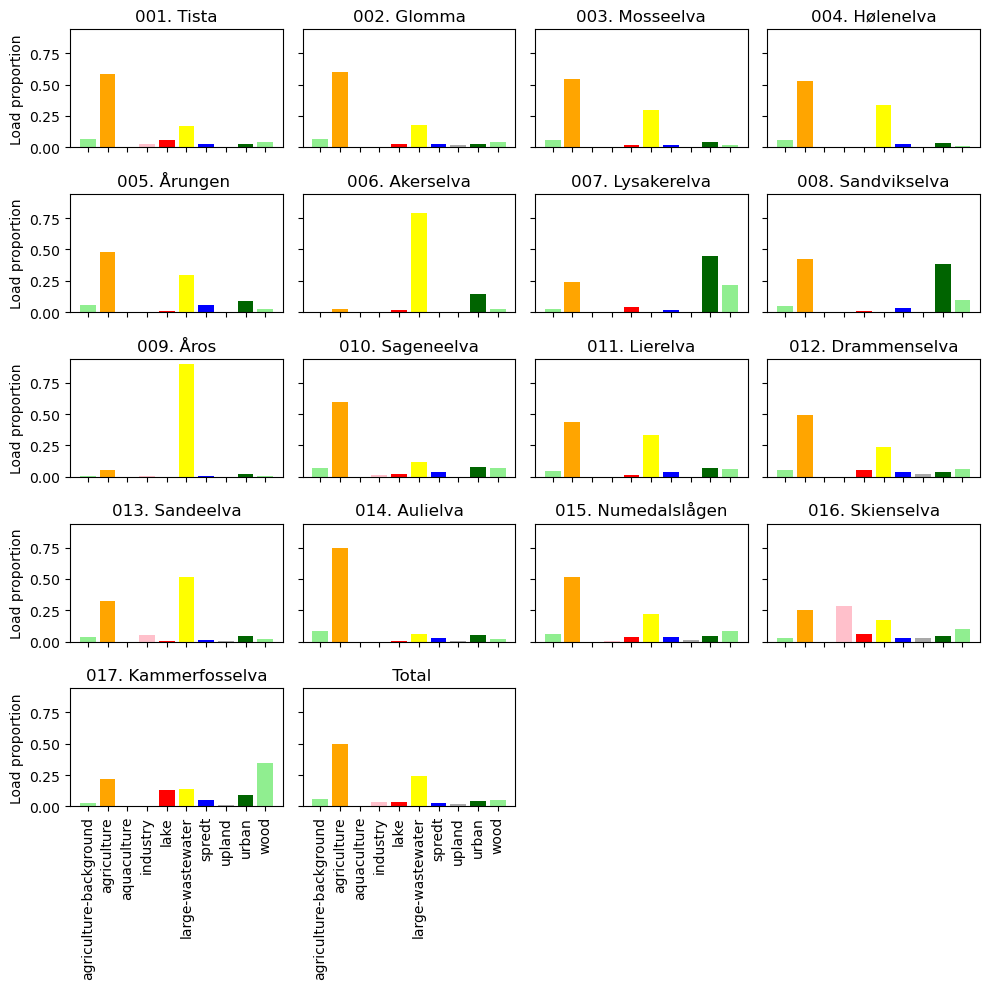

In [55]:
# # If aquaculture is always 0, drop
# if f_sector_df['aquaculture'].sum() == 0:
#     plot_df = f_sector_df.drop('aquaculture', axis=1)
# else:
#     plot_df = f_sector_df

plot_df = f_sector_df

num_columns = 4
num_rows = int(np.ceil(len(f_sector_df) / num_columns))

fig, axes = plt.subplots(num_rows, num_columns, sharex=True, sharey=True, figsize=(10, 10))
axes = axes.flatten()

# colors = ['light green', 'orange', 'gray', 'pink', 'red', 'yellow', 'blue', 'dark gray', 'dark green']
# colours translated to something that should plot
colors = ['#90ee90', '#ffa500', '#808080', '#ffc0cb', '#ff0000', '#ffff00', '#0000ff', '#a9a9a9', '#006400']
# Purple: '#800080'

for i, (num, row) in enumerate(plot_df.iterrows()):
    if num == 'Total':
        name = 'Total'
        vassom = ""
    else:
        name = river_meta_df.loc[num, 'river_name']
        vassom = river_meta_df.loc[num, 'Vassom']
    # name = river_meta_df.loc[num, 'river_name']
    # vassom = river_meta_df.loc[num, 'Vassom']
    axes[i].bar(row.index, row.values, color=colors)
    axes[i].set_title(f"{vassom} {name}")
    axes[i].tick_params(axis='x', rotation=90)
    if i % num_columns == 0:
        axes[i].set_ylabel('Load proportion')
    # axes[i].set_ylabel('Load proportion')

# Remove any unused subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
fpath = os.path.join(fig_folder, f"teotil_proportion_sector_inputs_{teotil_end_point}_{par}.png")
plt.savefig(fpath)
plt.show()

**Comments:**
- Agriculture dominates in most rivers
- Only Glomma, Drammenselva and Tista have noticeable sewage inputs when direct land-sea inputs are excluded
- Including land-sea inputs, sewage becomes much mroe important
- Urban inputs are substantial in the Oslo city rivers (Akerselva, Lysakerelva, Sandvikselva), though hard to see in Akerselva when large wastewater are included

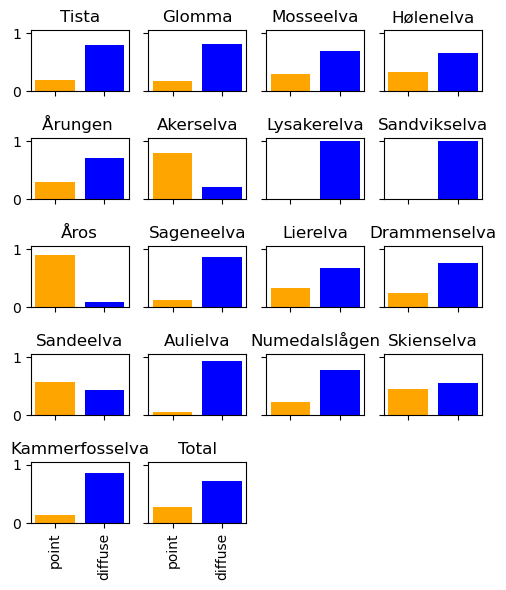

In [60]:
# Plot of point vs diffuse

plot_df = f_groupsector_df[['point', 'diffuse']]
num_columns = 4
num_rows = int(np.ceil(len(f_sector_df) / num_columns))

fig, axes = plt.subplots(num_rows, num_columns, sharex=True, sharey=True, figsize=(5, 6))
axes = axes.flatten()

# colours translated to something that should plot
colors = ['#ffa500', '#0000ff']

for i, (num, row) in enumerate(plot_df.iterrows()):
    name = river_meta_df.loc[num, 'river_name']
    axes[i].bar(row.index, row.values, color=colors)
    axes[i].set_title(f"{name}")
    axes[i].tick_params(axis='x', rotation=90)

# Remove any unused subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
fpath = os.path.join(fig_folder, f"teotil_proportion_pt-diffuse_{teotil_end_point}_{par}.png")
plt.savefig(fpath)
plt.show()

In [ ]:
# Plot of human vs natural

plot_df = f_groupsector_df[['human', 'natural']]
num_columns = 4
num_rows = int(np.ceil(len(f_sector_df) / num_columns))

fig, axes = plt.subplots(num_rows, num_columns, sharex=True, sharey=True, figsize=(5, 6))
axes = axes.flatten()

# colours translated to something that should plot
colors = ['#ffa500', '#0000ff']

for i, (num, row) in enumerate(plot_df.iterrows()):
    name = river_meta_df.loc[num, 'river_name']
    axes[i].bar(row.index, row.values, color=colors)
    axes[i].set_title(f"{name}")
    axes[i].tick_params(axis='x', rotation=90)

# Remove any unused subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
fpath = os.path.join(fig_folder, f"teotil_proportion_human-natural_{teotil_end_point}_{par}.png")
plt.savefig(fpath)
plt.show()

Akerselva, Lysakerelva, Tofteelva are the most 'natural' (i.e. human/natural inputs is smaller). The rest are very human-influenced.

# Read in daily river data netcdf & tidy

In [36]:
ds = xr.open_dataset(fpath_baseline_data)

# Select just the variables of interest
ds = ds[riv_var_li_dict[species]]
ds

<xarray.Dataset> Size: 11MB
Dimensions:          (river_time: 12053, real_river: 39)
Coordinates:
  * real_river       (real_river) float64 312B 1.0 2.0 3.0 ... 37.0 38.0 39.0
  * river_time       (river_time) datetime64[ns] 96kB 1990-01-01T12:00:00 ......
Data variables:
    river_NH4N       (river_time, real_river) float32 2MB ...
    river_NO3NO2N    (river_time, real_river) float32 2MB ...
    river_TOTN       (river_time, real_river) float32 2MB ...
    river_DON        (river_time, real_river) float32 2MB ...
    river_PON        (river_time, real_river) float32 2MB ...
    river_transport  (river_time, real_river) float32 2MB ...
Attributes:
    river_main_station_names_1-10:   1=Göta älv, Alelyckan; 2=Bäveån Uddevall...
    river_main_station_names_11-20:  11=Akerselva, hovedmålestasjon; 12=Lysak...
    river_main_station_names_21-30:  21=Numedalslågen ved Bommestad (E18); 22...
    river_main_station_names_31-39:  31=Kvina; 32=Klostergrøften, Klostergrøf...
    history:                         Thu Mar 21 17:07:47 2024: ncks -4 -L 5 m...
    NCO:                             4.7.2

In [37]:
# Convert to dataframe
# N.B. loose units info then. m3/s for Q, ug/l for rest
conc_df = ds.to_dataframe()
ds.close()

conc_df = conc_df.reset_index()  # Drop multiindex

# # Add river name to df
# conc_df['river_name'] = conc_df['real_river'].map(river_meta_df['river_name'])

# Select just the Oslofjord rivers
conc_df = conc_df[conc_df['real_river'].isin(oslofjord_riv_nos)]

# Calculate DIN and TON
conc_df['din'] = conc_df['river_NH4N'] + conc_df['river_NO3NO2N']
# Assume particulate organic N = 0, and that this is more robust than TON = PON+DON
conc_df['ton'] = conc_df['river_TOTN'] - conc_df['din']

# Convert all numeric columns to float64 (chem cols were float32)
conc_df[riv_var_li] = conc_df[riv_var_li].astype(float)

# Round concentrations to 3 d.p. (N.B. only appropriate for ug/l)
conc_df[chem_var_li] = conc_df[chem_var_li].round(3)

# Truncate to start and end date
conc_df = conc_df.query('@start_date <= river_time <= @end_date')

conc_df.tail()

river_time  real_river  river_NH4N  river_NO3NO2N  river_TOTN  \
470043 2022-12-31 12:00:00        16.0       9.192       1210.840    1338.208   
470044 2022-12-31 12:00:00        17.0      39.270        866.487    1393.936   
470045 2022-12-31 12:00:00        18.0      13.546        342.997     508.703   
470046 2022-12-31 12:00:00        19.0      19.452        113.672     378.166   
470047 2022-12-31 12:00:00        20.0     274.545       1641.914    2143.350   

        river_DON  river_PON  river_transport          din         ton  
470043    101.914     16.116         0.731608  1220.031982  118.176003  
470044    471.387     16.640        19.877710   905.757019  488.178986  
470045    135.739     16.272       258.239807   356.544006  152.158997  
470046    232.165     12.761        16.971445   133.123993  245.042007  
470047    209.739     16.999        39.055298  1916.458008  226.891998

In [38]:
# Explore for specific rivers/times
temp = conc_df.loc[conc_df['real_river'] == 14, ['river_time', 'river_NO3NO2N', 'river_transport']]

# Calculate daily & annual loads from the river data

## Daily loads

In [39]:
# Daily loads (kg/day)

# Make empty dataframe with just time & location info
daily_load_df = conc_df.drop(chem_var_li+['river_transport'], axis=1)

# Calculate load
for var in chem_var_li:
    # Units ug/l * m3/s * l/m3 * kg/ug * s/d = kg/d
    daily_load_df[var] = conc_df[var] * conc_df['river_transport'] * 10**3 * 10**-9 * 86400

chem_cols = daily_load_df.columns.drop(['river_time', 'real_river'])

daily_load_df.head()

river_time  real_river  river_NH4N  river_NO3NO2N  \
327644 2013-01-01 12:00:00         6.0   99.304292    4136.529999   
327645 2013-01-01 12:00:00         7.0  692.954032   10022.521099   
327646 2013-01-01 12:00:00         8.0  199.130873    1214.673897   
327647 2013-01-01 12:00:00         9.0   68.907812     444.080250   
327648 2013-01-01 12:00:00        10.0   48.569385     674.590934   

          river_TOTN    river_DON   river_PON           din          ton  
327644   7003.108914  2526.572795  238.531498   4235.834311  2767.274610  
327645  15417.079198  3971.521497  723.502474  10715.475200  4701.604138  
327646   2189.321439   725.723523   49.342304   1413.806793   775.514680  
327647    735.532002   213.324874    9.136322    512.988079   222.544318  
327648   1159.604665   427.357783    9.005329    723.159846   436.444786

In [40]:
# # What % of TON is PON?
# # daily_load_df.plot(kind='scatter', x='river_DON', y='river_PON')
# ratio = 100 * daily_load_df['river_PON']/daily_load_df['ton']
# ratio.describe()

## Annual loads

In [41]:
# Annual loads (kg/year)
annual_load_df = daily_load_df.copy().set_index('river_time')
annual_load_df = annual_load_df.groupby('real_river').resample('YE').sum()

# Tidy
annual_load_df.drop('real_river', axis=1, inplace=True)
annual_load_df.reset_index(inplace=True)

# # Convert to tonnes (10**3 kg) per year
# annual_load_df[chem_cols] = annual_load_df[chem_cols]/1000

annual_load_df['year'] = annual_load_df['river_time'].dt.year
annual_load_df.drop('river_time', axis=1, inplace=True)

annual_load_df

real_river    river_NH4N  river_NO3NO2N    river_TOTN      river_DON  \
0           6.0  12148.756964   4.696627e+05  8.548883e+05  348684.806476   
1           6.0  24691.520987   7.179538e+05  1.250792e+06  475092.293767   
2           6.0  12583.748320   6.601110e+05  1.144701e+06  440762.570758   
3           6.0   4797.933241   4.289918e+05  7.312321e+05  278736.468703   
4           6.0  13040.528094   5.503839e+05  9.138086e+05  329938.122509   
..          ...           ...            ...           ...            ...   
145        20.0  38339.002290   1.462085e+06  1.740374e+06  232419.643202   
146        20.0  91712.170890   1.822525e+06  2.073845e+06  143126.576566   
147        20.0  57215.250183   1.446076e+06  1.696930e+06  179414.366692   
148        20.0  84678.923005   1.018992e+06  1.320784e+06  208575.738556   
149        20.0  38236.392991   1.028860e+06  1.277713e+06  203489.256856   

        river_PON           din            ton  year  
0    24172.481743  4.818115e+05  373076.835932  2013  
1    32759.244722  7.426454e+05  508146.259677  2014  
2    30962.687071  6.726948e+05  472006.466481  2015  
3    18537.616741  4.337896e+05  297442.459635  2016  
4    20261.996188  5.634244e+05  350384.186715  2017  
..            ...           ...            ...   ...  
145   7462.601503  1.500424e+06  239950.040393  2018  
146  16366.050079  1.914237e+06  159607.813147  2019  
147  14098.026588  1.503292e+06  193638.226411  2020  
148   8460.393411  1.103671e+06  217112.974208  2021  
149   7062.999581  1.067096e+06  210616.381895  2022  

[150 rows x 9 columns]

In [54]:
(annual_load_df.loc[annual_load_df['real_river'] == 16].set_index('real_river') / 1000)

river_NH4N  river_NO3NO2N  river_TOTN  river_DON  river_PON  \
real_river                                                                
16.0          0.066557       3.392190    3.540541   0.019334   0.062384   
16.0          0.109069       6.354589    6.580037   0.008003   0.108345   
16.0          0.124441       6.322418    6.607696   0.042537   0.118181   
16.0          0.101257       4.837473    5.091365   0.061130   0.091359   
16.0          0.136264       6.663740    7.160395   0.241537   0.118543   
16.0          0.166734       3.399007    5.497752   1.850439   0.080838   
16.0          0.164280       3.766520    6.724534   2.624883   0.167332   
16.0          0.157733       2.403516    6.928514   4.195384   0.170334   
16.0          0.156892       2.845491    5.764943   2.639307   0.122144   
16.0          0.057690       5.681276    6.415014   0.591092   0.084191   

                 din       ton   year  
real_river                             
16.0        3.458747  0.081794  2.013  
16.0        6.463658  0.116379  2.014  
16.0        6.446858  0.160837  2.015  
16.0        4.938731  0.152634  2.016  
16.0        6.800005  0.360391  2.017  
16.0        3.565741  1.932011  2.018  
16.0        3.930800  2.793734  2.019  
16.0        2.561248  4.367265  2.020  
16.0        3.002383  2.762560  2.021  
16.0        5.738966  0.676048  2.022

# Compare TEOTIL and river data annual loads 

Compare annual river load DIN datawith the loads per real river derived by area-scaling TEOTIL regine inputs (& excluding direct WWTW inputs to the fjord).

In [43]:
s2

real_river
6      559.303131
7     9465.586204
8      284.752111
9      238.925878
10     321.095982
11      61.755401
12      40.234199
13      93.497314
14     119.205356
15       9.571020
16      42.016651
17     147.088217
18    2417.624800
19     238.586596
20     861.961975
Name: total, dtype: float64

In [55]:
s1

real_river
6.0      679.384078
7.0     8352.007618
8.0      341.845051
9.0      197.223058
10.0     149.972715
11.0      44.722989
12.0      29.794402
13.0      88.847243
14.0     310.935023
15.0      33.310298
16.0       4.690714
17.0     178.173504
18.0    3195.956365
19.0     100.184482
20.0    1212.966648
Name: din, dtype: float64

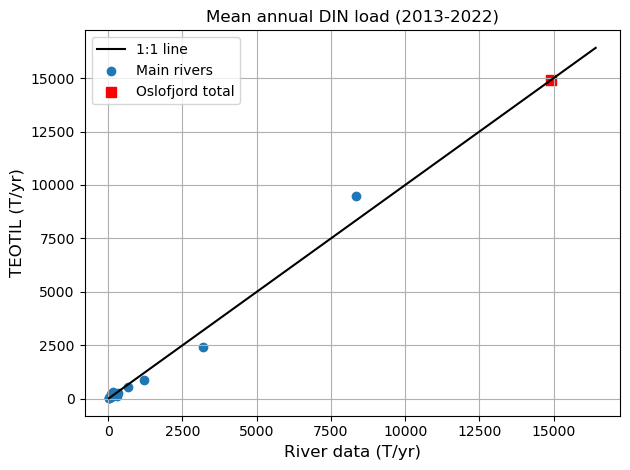

In [60]:
# Optionally just for 2018
# s1 = annual_load_df.loc[annual_load_df["year"] == 2018].set_index("real_river")["din"] / 1000
s1 = annual_load_df.groupby('real_river').mean()["din"] / 1000  # Average over years
s2 = teotil_scaled_riv_df["total"].copy() / 1000

# Sum up rivers 15 and 16 to make inputs for just the 1 MCA
# Don't trust that they're the right way round in the of800 data, the raw data seems to be 
# too low for Sageneelva (back of envelope, expect more like 30-50 T/yr), and too high in Tofteelva
s1.loc[16] = s1.loc[[15, 16]].sum()
s1.drop(15, axis=0, inplace=True)
s2.loc[16] = s2.loc[[15, 16]].sum()
s2.drop(15, axis=0, inplace=True)

total_riv = s1.sum()
total_teotil = s2.sum()
load_max = max(total_riv, total_teotil) * 1.1

plot_df = pd.concat([s1, s2], axis=1)
plot_df.columns = ["river data", "teotil"]

# Add a 1:1 line
plt.plot(
    [plot_df["river data"].min(), load_max],
    [plot_df["river data"].min(), load_max],
    color="k",
    label="1:1 line",
)

ax = plt.scatter(plot_df["river data"], plot_df["teotil"], label="Main rivers")

# Add the OF totals
plt.scatter(
    total_riv, total_teotil, marker="s", s=50, color="r", label="Oslofjord total"
)

# plt.xscale('log')
# plt.yscale('log')
plt.grid(True)

# Annotate with the real river number
# offset = 1.05
# for i, point in plot_df.iterrows():
#     plt.annotate(format(int(i), 'd'), (point['river data']*offset, point['teotil']*offset))

plt.legend()
plt.ylabel("TEOTIL (T/yr)", size=12)
plt.xlabel("River data (T/yr)", size=12)
plt.title("Mean annual DIN load (2013-2022)")

plt.tight_layout()

fname = "teotil_vs_rivdata_annual_loads.png"
# fname = "teotil_vs_rivdata_annual_loads_logscale.png"
# fname = "teotil_vs_rivdata_annual_loads_logscale_annotated.png"
fpath = os.path.join(fig_folder, fname)
plt.savefig(fpath)

plt.show()

**Comments:**

- The points mostly lie on the 1:1 line!
- Glomma is almost perfectly on the 1:1 line, and so is the total for the whole OF
- Some rivers are a bit off the line. Especially 10, 19, 16 (TEOTIL load > river load); 14 (river data load > TEOTIL load)

Overall, the good agreement is promising. First check that it's ok to use TEOTIL to split the sources. Suggests it's a bit dodgy for some of the rivers, but ok for the larger ones and for the OF as a whole. Whether TEOTIL gets that source apportionment right is another issue, but this is good.

# Split river data annual loads by sector
Using proportions from TEOTIL averaged over the period 2013-2022 (at the moment)

In [63]:
# Just get annual loads for TEOTIL variable. Current one is din
annual_load_df_var = annual_load_df[['real_river', 'year', par]]
annual_load_df_var.set_index('real_river', inplace=True)

# Get the right f_sector_df and drop the 'total' row
f_sector_df = f_sector_df_dict['Regine'].copy()
f_sector_df = f_sector_df.drop(['Total'], axis=0)

merged_df = annual_load_df_var.join(f_sector_df, how='left')
# Drop any Swedish rivers not present in TEOTIL
merged_df.dropna(how='any', inplace=True)

annual_sector_df = pd.DataFrame(index=merged_df.index)
annual_sector_df['year'] = merged_df['year']

for sector in f_sector_df.columns:
    annual_sector_df[sector] = merged_df[par] * merged_df[sector]

annual_sector_df.reset_index(inplace=True)

# Drop years outside the model data range
annual_sector_df = annual_sector_df.query('@start_year <= year <= @end_year')

annual_sector_df

real_river  year  agriculture-background   agriculture  aquaculture  \
0           6.0  2013            33818.013412  3.043621e+05          0.0   
1           6.0  2014            52125.768578  4.691319e+05          0.0   
2           6.0  2015            47215.980962  4.249438e+05          0.0   
3           6.0  2016            30447.395468  2.740266e+05          0.0   
4           6.0  2017            39546.372598  3.559174e+05          0.0   
..          ...   ...                     ...           ...          ...   
145        20.0  2018           133929.637046  1.205367e+06          0.0   
146        20.0  2019           170867.064783  1.537804e+06          0.0   
147        20.0  2020           134185.603063  1.207670e+06          0.0   
148        20.0  2021            98514.955789  8.866346e+05          0.0   
149        20.0  2022            95250.267815  8.572524e+05          0.0   

         industry          lake  large-wastewater        spredt       upland  \
0    22483.520377  40739.021478      23887.437691  15544.867313  1450.068900   
1    34655.222520  62793.540820      36819.165982  23960.252965  2235.079718   
2    31391.006241  56878.943156      33351.125316  21703.408481  2024.554924   
3    20242.603493  36678.591459      21506.593342  13995.521168  1305.541538   
4    26291.954625  47639.715054      27933.678416  18177.978323  1695.692893   
..            ...           ...               ...           ...          ...   
145      0.000000   4189.378183      44455.826966  38571.341184   392.799409   
146      0.000000   5344.797232      56716.622501  49209.211630   501.132412   
147      0.000000   4197.384913      44540.790840  38645.058644   393.550126   
148      0.000000   3081.591316      32700.483065  28372.017242   288.932437   
149      0.000000   2979.470434      31616.821473  27431.796717   279.357502   

            urban          wood  
0    12405.845761  27120.559836  
1    19121.887417  41802.574518  
2    17320.774290  37865.140725  
3    11169.363717  24417.472445  
4    14507.244789  31714.452037  
..            ...           ...  
145  39254.376969  34263.934114  
146  50080.626816  43713.833466  
147  39329.399844  34329.419266  
148  28874.439570  25203.607124  
149  27917.569267  24368.384569  

[150 rows x 12 columns]

In [64]:
# Sum up to estimate point, diffuse, human sums
annual_groupsector_df = annual_sector_df[['real_river', 'year']].copy()
annual_groupsector_df['point'] = annual_sector_df[point_source_li].sum(axis=1)
annual_groupsector_df['diffuse'] = annual_sector_df[diffuse_source_li].sum(axis=1)
annual_groupsector_df['human'] = annual_sector_df[human_source_li].sum(axis=1)
annual_groupsector_df['natural'] = annual_sector_df[natural_source_li].sum(axis=1)
annual_groupsector_df['total'] = annual_groupsector_df['point'] + annual_groupsector_df['diffuse']

annual_groupsector_df

real_river  year         point       diffuse         human  \
0           6.0  2013  46370.958068  4.354405e+05  3.786838e+05   
1           6.0  2014  71474.388502  6.711710e+05  5.836884e+05   
2           6.0  2015  64742.131557  6.079526e+05  5.287101e+05   
3           6.0  2016  41749.196835  3.920404e+05  3.409406e+05   
4           6.0  2017  54225.633041  5.091988e+05  4.428282e+05   
..          ...   ...           ...           ...           ...   
145        20.0  2018  44455.826966  1.455968e+06  1.327648e+06   
146        20.0  2019  56716.622501  1.857520e+06  1.693810e+06   
147        20.0  2020  44540.790840  1.458751e+06  1.330186e+06   
148        20.0  2021  32700.483065  1.070970e+06  9.765815e+05   
149        20.0  2022  31616.821473  1.035479e+06  9.442186e+05   

           natural         total  
0    103127.663626  4.818115e+05  
1    158956.963633  7.426454e+05  
2    143984.619767  6.726948e+05  
3     92849.000910  4.337896e+05  
4    120596.232581  5.634244e+05  
..             ...           ...  
145  172775.748752  1.500424e+06  
146  220426.827892  1.914237e+06  
147  173105.957368  1.503292e+06  
148  127089.086665  1.103671e+06  
149  122877.480321  1.067096e+06  

[150 rows x 7 columns]

## Sum up over vassdragsområder

Just pick 2018, for comparability with OF800 WWTW data

In [65]:
# annual_sector_vassom_df = annual_sector_df.copy()

# annual_sector_vassom_df = annual_sector_vassom_df.loc[annual_sector_vassom_df['year'] == 2018].reset_index()

# # Sum over vassdragsområder (only affects 2 rivers here - real rivers 15 and 16 which are both in vassom 10)
# annual_sector_vassom_df['Vassom'] = annual_sector_vassom_df['real_river'].map(river_meta_df['Vassom'])
# cols_to_sum = list(annual_sector_df.columns.drop(['real_river', 'year']))
# annual_sector_vassom_df = annual_sector_vassom_df[cols_to_sum + ['Vassom']].groupby('Vassom').sum()

# # Add direct WWTW inputs

# # Select just DIN & convert to kg/year to match units of river data
# direct_wwtp_inputs = direct_wwtp_annual_df['DIN'] * 1000
# direct_wwtp_inputs.name = 'direct-wwtw'

# annual_sector_vassom_df = annual_sector_vassom_df.join(direct_wwtp_inputs)

# # Fill NaNs in direct-wwtw with 0 (where that vassom has no direct inputs)
# annual_sector_vassom_df['direct-wwtw'] = annual_sector_vassom_df['direct-wwtw'].fillna(0)

# annual_sector_vassom_df

# Estimate daily loads from point sources vs diffuse sources
Key assumptions: constant daily load from point sources, irrespective of discharge; input from diffuse sources increases with discharge in an undefined way. So first estimate point source contribution to load, then estimate diffuse input by difference:
- Total daily load (already calculated above), L_tot =C_t Q_t
- Daily load from point sources, L(pt,daily) = L_pt,whole-period / number of days in the model period
- Daily load from diffuse sources, L(diffuse, daily) = L(tot, daily) - L(pt, daily)
- Plots to check looks sensible. What to do with negative values?e


In [66]:
# Estimate point sources as a constant daily input over the whole period

# Sum up over the whole model period (start of start year to end of end year)
annual_point_df_sum = (
    annual_groupsector_df[["real_river", "year", "point"]].groupby("real_river").sum()
)
annual_point_df_sum.drop("year", axis=1, inplace=True)

# Divide by the number of days in the whole model period
tot_days = end_date - start_date
tot_days = tot_days.days

daily_point_df = annual_point_df_sum / tot_days
daily_point_df.head()

point
real_river             
6.0          179.041432
7.0         3295.989665
8.0           16.850147
9.0            7.734803
10.0           2.259376

In [67]:
# # Estimate point sources as a constant daily input per year

# daily_point_df = annual_groupsector_df[['real_river', 'year']].copy()
# daily_point_df['point'] = annual_groupsector_df['point'] / 365

# # Convert 'year' to datetime, add a row at the start for interpolation of the full time period
# daily_point_df['year'] = pd.to_datetime(daily_point_df['year'], format='%Y') + pd.offsets.YearEnd(1)
# first_row = daily_point_df.iloc[0].copy()
# first_row['year'] = datetime.datetime(first_row['year'].year, 1, 1)
# daily_point_df = pd.concat([pd.DataFrame(first_row).T, daily_point_df], ignore_index=True).reset_index(drop=True)
# daily_point_df.rename(columns={'year':'date'}, inplace=True)

# daily_point_df.set_index(['real_river', 'date'], inplace=True)

# # Resample to daily frequency & interpolate
# daily_point_df = daily_point_df.groupby(level=0).resample('D', level=1).mean()
# daily_point_df['point'] = daily_point_df.groupby(level=0, group_keys=False)['point'].apply(lambda group: group.interpolate())

# # # Reset index
# # # daily_point_df.reset_index(inplace=True)

# daily_point_df

In [68]:
# Get daily load data for just the TEOTIL chemical variable of interest
daily_load_df_var = daily_load_df[['real_river', 'river_time', par]].copy()

# Reformat & rename columns
daily_load_df_var.columns = ['real_river', 'date', 'total']
# Drop 12:00 time info from the dates, for compatibility with other dfs
daily_load_df_var['date'] = daily_load_df_var['date'].dt.normalize()
daily_load_df_var.set_index(['real_river', 'date'], inplace=True)
# print(daily_load_df_var.head())

# Join the daily load df with the estimated daily point inputs
calc_load_df = daily_load_df_var.join(daily_point_df, on='real_river', how='outer')

# Estimate diffuse inputs by subtracting point from total
calc_load_df['diffuse_raw'] = calc_load_df['total'] - calc_load_df['point']

calc_load_df

total       point  diffuse_raw
real_river date                                            
6.0        2013-01-01  4235.834311  179.041432  4056.792879
           2013-01-02  3918.087439  179.041432  3739.046007
           2013-01-03  1991.311006  179.041432  1812.269574
           2013-01-04  1963.764012  179.041432  1784.722580
           2013-01-05  1890.143944  179.041432  1711.102512
...                            ...         ...          ...
20.0       2022-12-27  6312.893951   98.408537  6214.485414
           2022-12-28  6352.336934   98.408537  6253.928397
           2022-12-29  6391.311161   98.408537  6292.902625
           2022-12-30  6429.546008   98.408537  6331.137471
           2022-12-31  6466.853230   98.408537  6368.444694

[54780 rows x 3 columns]

## Plot uncorrected

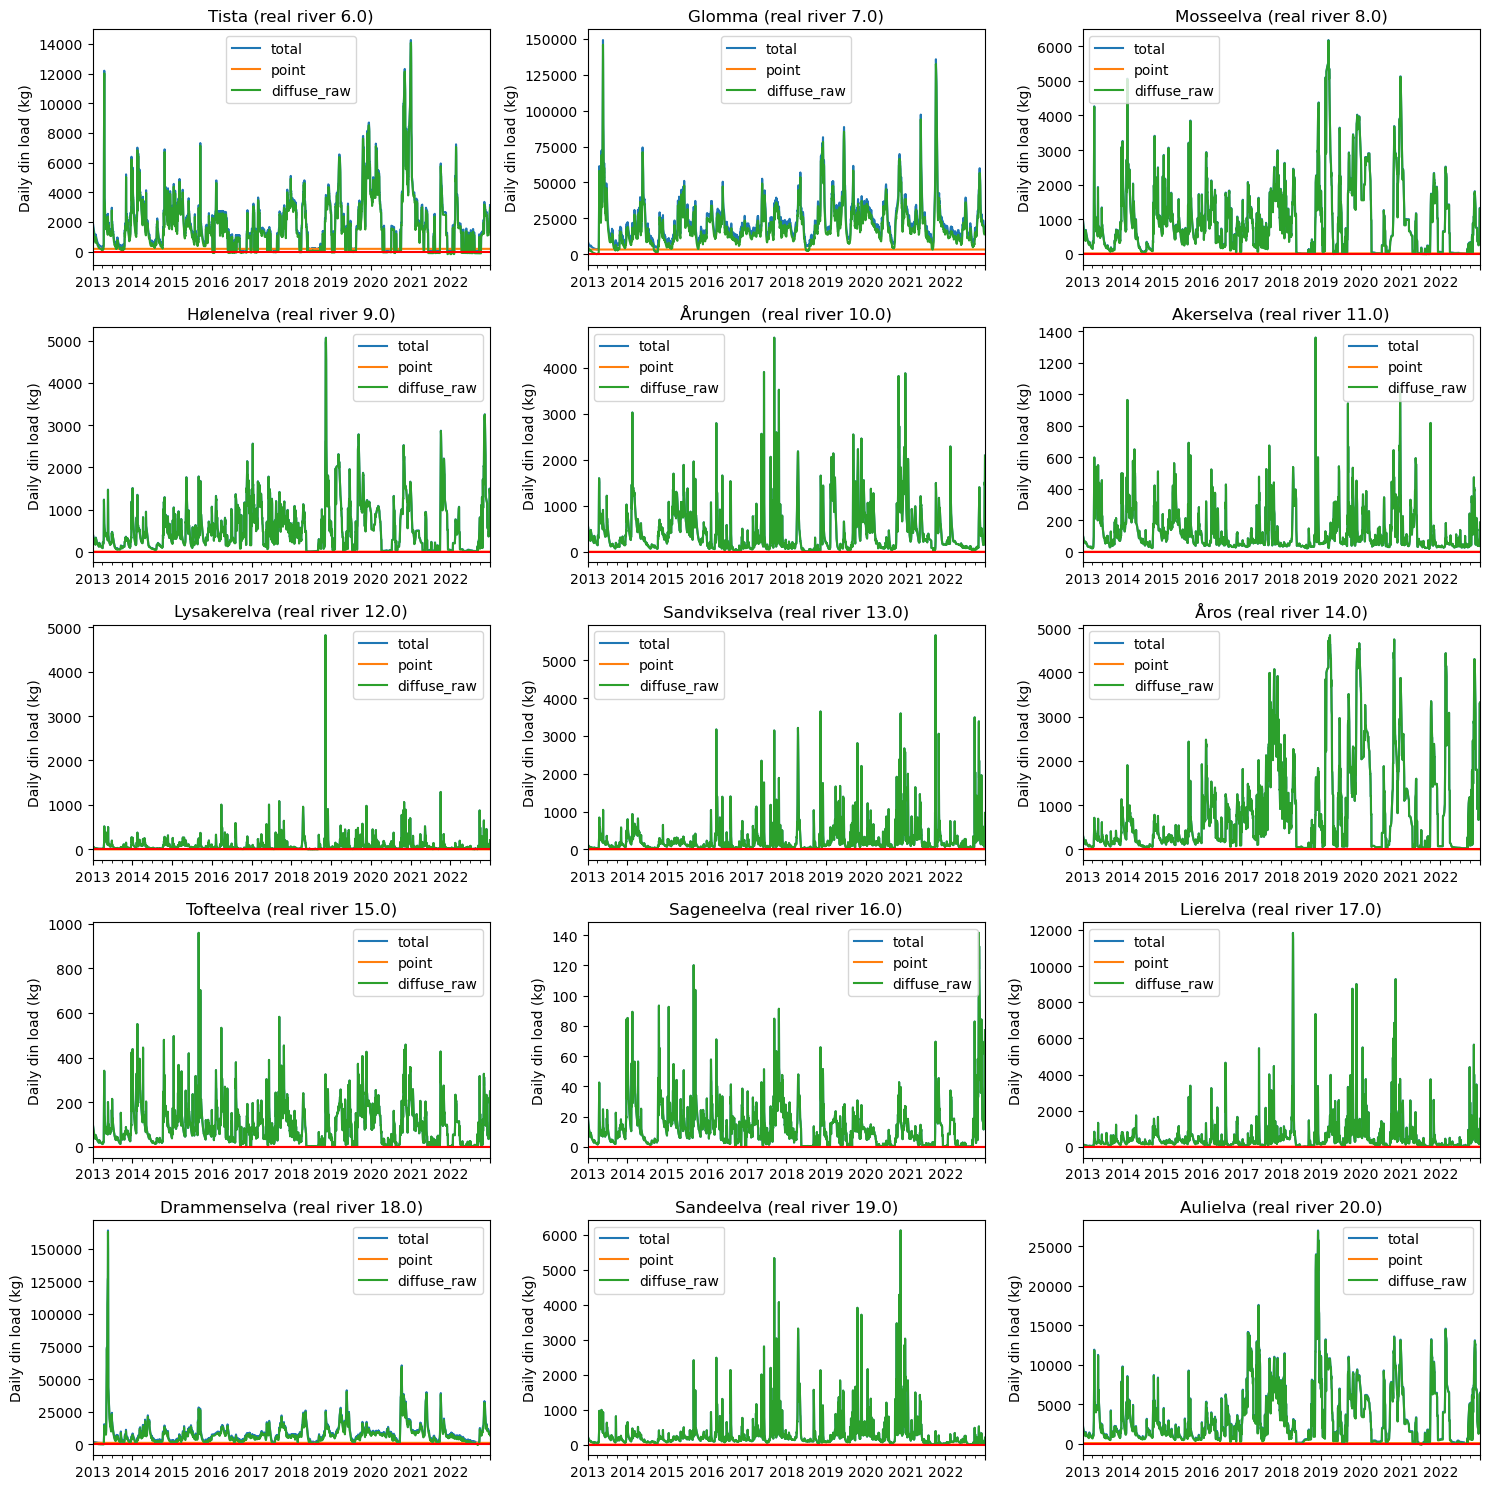

In [69]:
real_rivers = calc_load_df.index.get_level_values('real_river').unique()

n_rows = int(np.ceil(len(real_rivers) / 3))
fig, axs = plt.subplots(n_rows, 3, figsize=(15, n_rows*3))
axs = axs.flatten()

# For each real_river
for i, real_river in enumerate(real_rivers):
    name = river_meta_df.loc[real_river, 'river_name']
    df = calc_load_df.loc[real_river]
    df.plot(ax=axs[i])
    axs[i].axhline(0, color='r')
    axs[i].set_xlabel('')
    axs[i].set_ylabel(r'Daily %s load (kg)' % par)
    axs[i].set_title(f'{name} (real river {real_river})')
    axs[i].legend()

plt.tight_layout()
plt.show()

**Comments**

**This is extremely influenced by the choice of whether to summarise TEOTIL inputs over the whole vassdragsområde or just the downstream regine associated with the main river**. The whole vassdragsområde includes point source inputs directly to the sea (e.g. VEAS), so of course this approach won't work for the whole vassdragsområde, unless these direct land-sea fluxes are first subtracted from the TEOTIL point sources. Perhaps something to look into for the future. For now, just go with the downstream REGINE as the TEOTIL unit.

Then, point source inputs are minor. The river with the highest point source inputs is in fact Glomma, at 20%. The approach works well everywhere including there, i.e. after subtracting daily point inputs during low flows, we're not going particularly negative.

There are however small negative values that need to be removed. These are small, so it's not worth fiddling too much... Approach: sum up the absolute of the negative over the whole period, divide by the days in the period, and then subtract from the diffuse load for days where this is > (total - point) inputs

## Redistribute negative mass

In [70]:
def remove_negatives(row):
    if row['point'] > row['total']:
        row['leftover'] = row['point'] - row['total']
        row['point'] = row['total']
        row['diffuse'] = 0
    else:
        row['point'] = row['point']
        row['diffuse'] = row['diffuse']
        row['leftover'] = 0
    return row

def redistribute_leftover(df):
    leftover_mass = df['leftover'].sum()
    n_days = len(df[df['diffuse'] > 0])
    mask = df['diffuse'] > 0
    df.loc[mask, 'point'] = df.loc[mask, 'point'] + leftover_mass / n_days
    df.loc[mask, 'diffuse'] = df.loc[mask, 'total'] - df.loc[mask, 'point']
    df['leftover'] = 0
    return df


In [71]:
# # Test case for developing
# df = pd.DataFrame({'total': [12, 10, 30, 5], 'point_raw': [10, 10, 10, 10]}, index=[1,2,3,4])
# df['diffuse_raw'] = df['total'] - df['point_raw']

# # Set up for looping
# df['leftover'] = 0
# df['diffuse'] = df['diffuse_raw']
# df['point'] = df['point_raw']

# # First iteration
# print('Start')
# print(df)

# counter=0
# max_iterations = 20
# while len(df.loc[df['diffuse'] < 0]) > 0:
#     print('iteration %s' % counter)
#     if counter >= max_iterations:
#         print(f"Maximum number of iterations reached: {max_iterations}")
#         break
#     df = df.apply(remove_negatives, axis=1)
#     df = redistribute_leftover(df)
#     print(df)
#     counter += 1

In [72]:
# Apply to real data
calc_load_df = daily_load_df_var.join(daily_point_df, on='real_river', how='outer')

riv_nos = calc_load_df.index.get_level_values(0).unique().tolist()

daily_load_dict = {}  # Do away with multi-indexing! Use a dict instead from now on
                      # Key: river number, returns df with datetime index, one col per source
                      # or combined sources

# Apply to real data
for riv_no in riv_nos:
    df = calc_load_df.loc[riv_no].copy()

    df['diffuse_raw'] = df['total'] - df['point']
    df['diffuse'] = df['diffuse_raw']
    df['leftover'] = 0
    df['point_raw'] = df['point']

    # print(f'Start {riv_no}')
    # print(df.round(1))

    counter = 0
    max_iterations = 20
    while len(df.loc[df['diffuse'] < 0]) > 0:
        # print('iteration %s' % counter)
        if counter >= max_iterations:
            print(f"Maximum number of iterations reached: {max_iterations}")
            break
        df = df.apply(remove_negatives, axis=1)
        df = redistribute_leftover(df)
        counter += 1

    print(f"River {riv_no}: {counter} iterations to redistribute mass")

    # Check original point source inputs and final ones are equal
    if df['point_raw'].sum().round(1) != df['point'].sum().round(1):
        print("New point source doesn't add up")

    df = df[['total', 'diffuse', 'point']]
    daily_load_dict[riv_no] = df

River 6.0: 3 iterations to redistribute mass
River 7.0: 0 iterations to redistribute mass
River 8.0: 2 iterations to redistribute mass
River 9.0: 0 iterations to redistribute mass
River 10.0: 0 iterations to redistribute mass
River 11.0: 0 iterations to redistribute mass
River 12.0: 0 iterations to redistribute mass
River 13.0: 0 iterations to redistribute mass
River 14.0: 0 iterations to redistribute mass
River 15.0: 0 iterations to redistribute mass
River 16.0: 0 iterations to redistribute mass
River 17.0: 1 iterations to redistribute mass
River 18.0: 1 iterations to redistribute mass
River 19.0: 0 iterations to redistribute mass
River 20.0: 1 iterations to redistribute mass


## Plot result

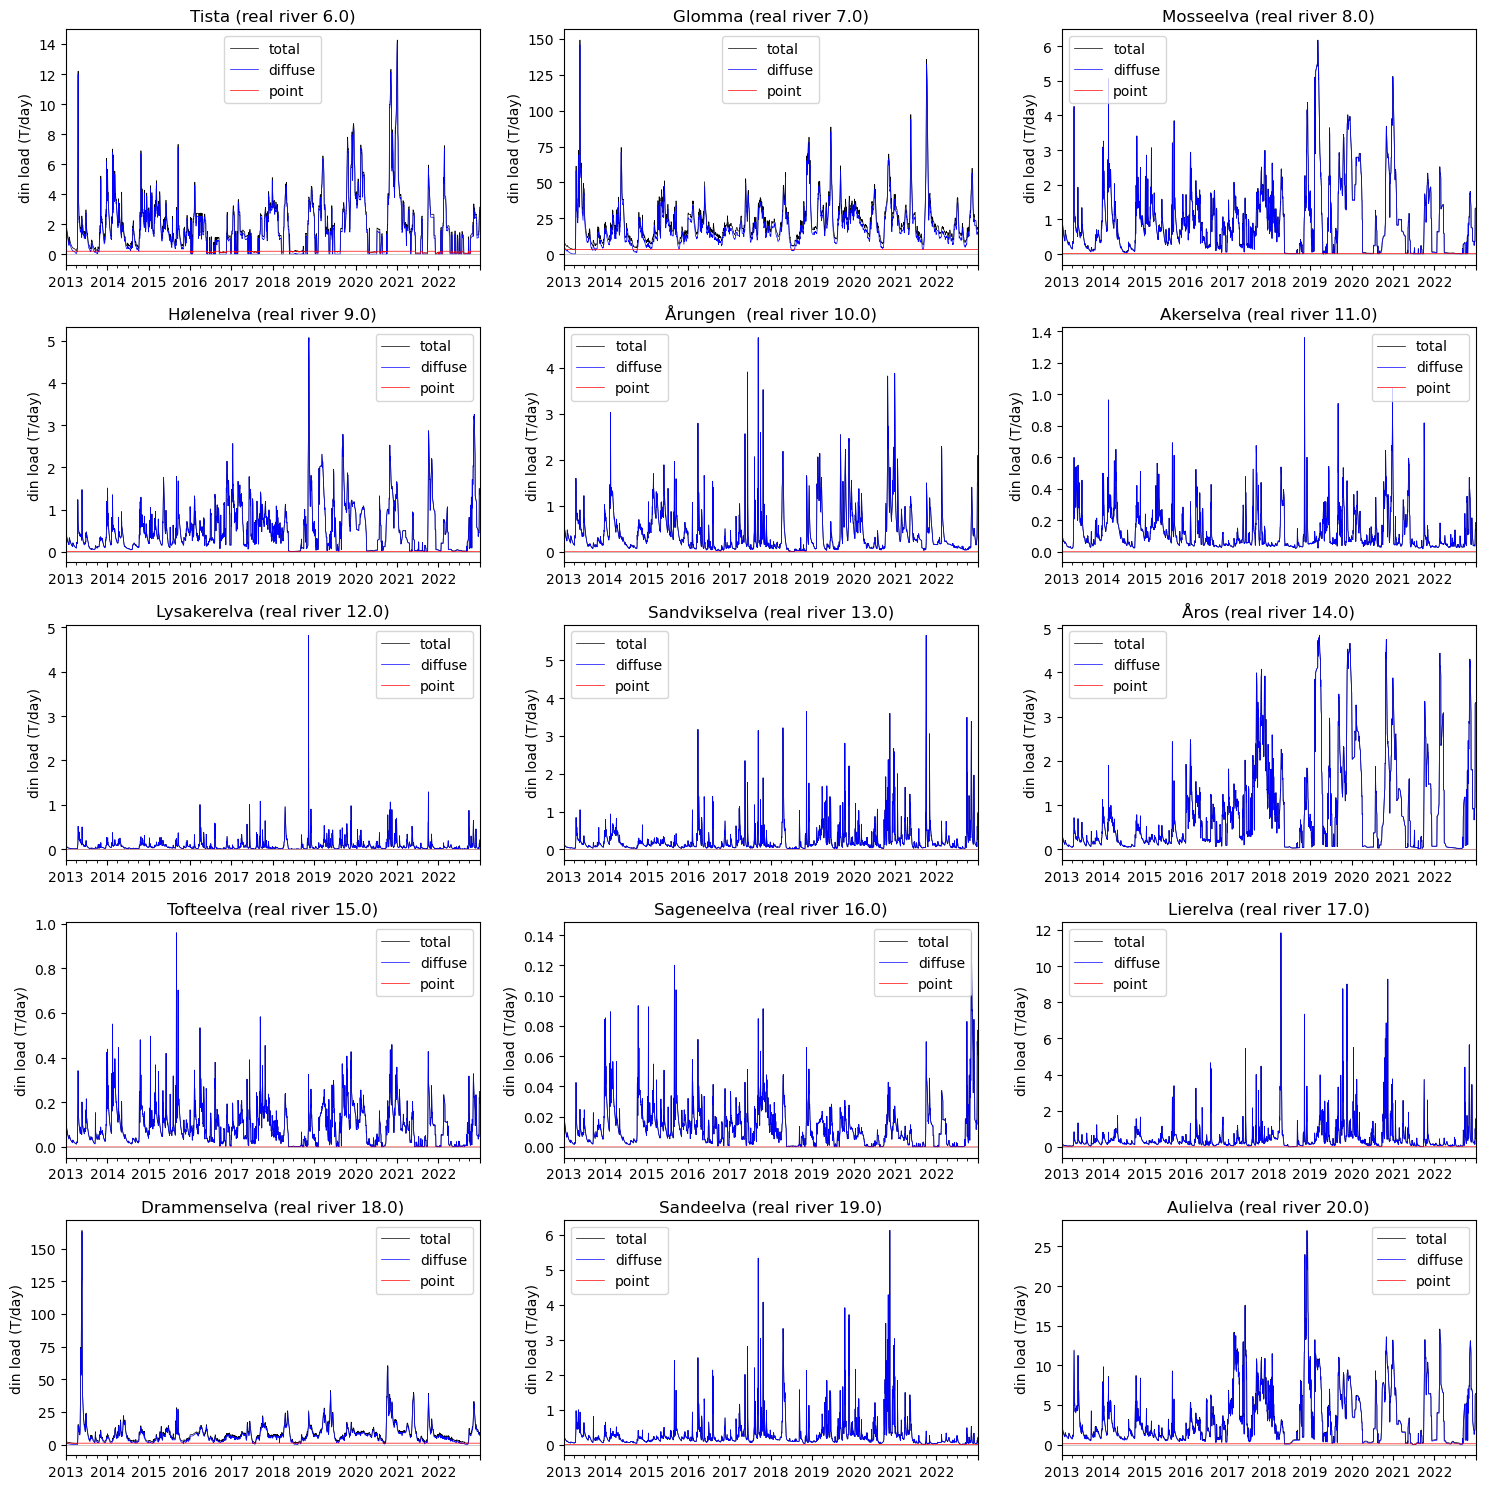

In [73]:
n_rows = int(np.ceil(len(real_rivers) / 3))
fig, axs = plt.subplots(n_rows, 3, figsize=(15, n_rows * 3))
axs = axs.flatten()
color_li = ["k", "b", "r"]

# For each real_river
for i, real_river in enumerate(real_rivers):
    name = river_meta_df.loc[real_river, "river_name"]
    df = daily_load_dict[real_river] / 1000
    df.plot(ax=axs[i], color=color_li, linewidth=0.5)
    axs[i].axhline(0, color="0.7", linewidth=0.5)
    axs[i].set_xlabel("")
    axs[i].set_ylabel(r"%s load (T/day)" % par)
    axs[i].set_title(f"{name} (real river {real_river})")
    axs[i].legend()

plt.tight_layout()
fpath = os.path.join(fig_folder, "daily_riv-only_pt-vs-diffuse_ts.png")
plt.savefig(fpath)
plt.show()

# Daily loads from all sectors

Do this based on:
1) The proportion of point source inputs which are large sewage vs industry
2) The proportion of diffuse source inputs which are agriculture, urban and spredt (the rest are "natural")

Then estimate daily loads as this proportion multiplied by the total daily load from point of diffuse sources.

In [74]:
for riv_no in riv_nos:
    # Alter df inplace in the dictionary (unless make a copy here)
    df = daily_load_dict[riv_no]

    for source in human_diffuse_source_li:
        df[source] = f_sector_diffuse_df_dict['Regine'].loc[riv_no, source] * df["diffuse"]

    for source in point_source_li:
        df[source] = f_sector_point_df_dict['Regine'].loc[riv_no, source] * df["point"]
        # f_sector_point_df has NaNs where the total point load was 0. Results in
        # NaNs for the daily load per sector. Replace with 0
        df[source]= df[source].fillna(0)

    df["background"] = df["total"] - df[human_diffuse_source_li + point_source_li].sum(axis=1)

    # Rename 'spredt'
    df.rename(columns={"spredt": "small-wastewater"}, inplace=True)

If none of the rivers have any aquaculture inputs (they probably shouldn't), then drop this column altogether

In [75]:
rivs_with_aquaculture = []
for riv_no in riv_nos:
    # Alter df inplace in the dictionary (unless make a copy here)
    df = daily_load_dict[riv_no]
    if df['aquaculture'].eq(0).all():
        # print(f'{riv_no}: all aquaculture inputs = 0')
        pass
    else:
        rivs_with_aquaculture.append(riv_no)

if len(rivs_with_aquaculture) == 0:
    print('Dropping aquaculture column')
    for riv_no in riv_nos:
        df = daily_load_dict[riv_no]
        df.drop('aquaculture', axis=1, inplace=True)
else:
    print(f'Rivers with aquaculture inputs: {rivs_with_aquaculture}')

Dropping aquaculture column


In [76]:
# Quick look at output e.g. for Glomma
daily_load_dict[7].head()

total      diffuse        point  agriculture  \
date                                                              
2013-01-01  10715.475200  7419.485535  3295.989665  5443.613358   
2013-01-02   9554.927811  6258.938146  3295.989665  4592.129621   
2013-01-03   8966.079073  5670.089408  3295.989665  4160.096316   
2013-01-04   8819.291185  5523.301520  3295.989665  4052.399293   
2013-01-05   8609.265870  5313.276205  3295.989665  3898.305508   

            small-wastewater       urban  industry  large-wastewater  \
date                                                                   
2013-01-01        268.255362  245.637937  7.175898       3288.813767   
2013-01-02        226.295167  207.215533  7.175898       3288.813767   
2013-01-03        205.005034  187.720437  7.175898       3288.813767   
2013-01-04        199.697841  182.860710  7.175898       3288.813767   
2013-01-05        192.104267  175.907372  7.175898       3288.813767   

             background  
date                     
2013-01-01  1461.978879  
2013-01-02  1233.297825  
2013-01-03  1117.267621  
2013-01-04  1088.343676  
2013-01-05  1046.959058

## Plot by real river

**To do:**
- Turn into stacked line chart?
- Use this function for plots above (& move function up!)

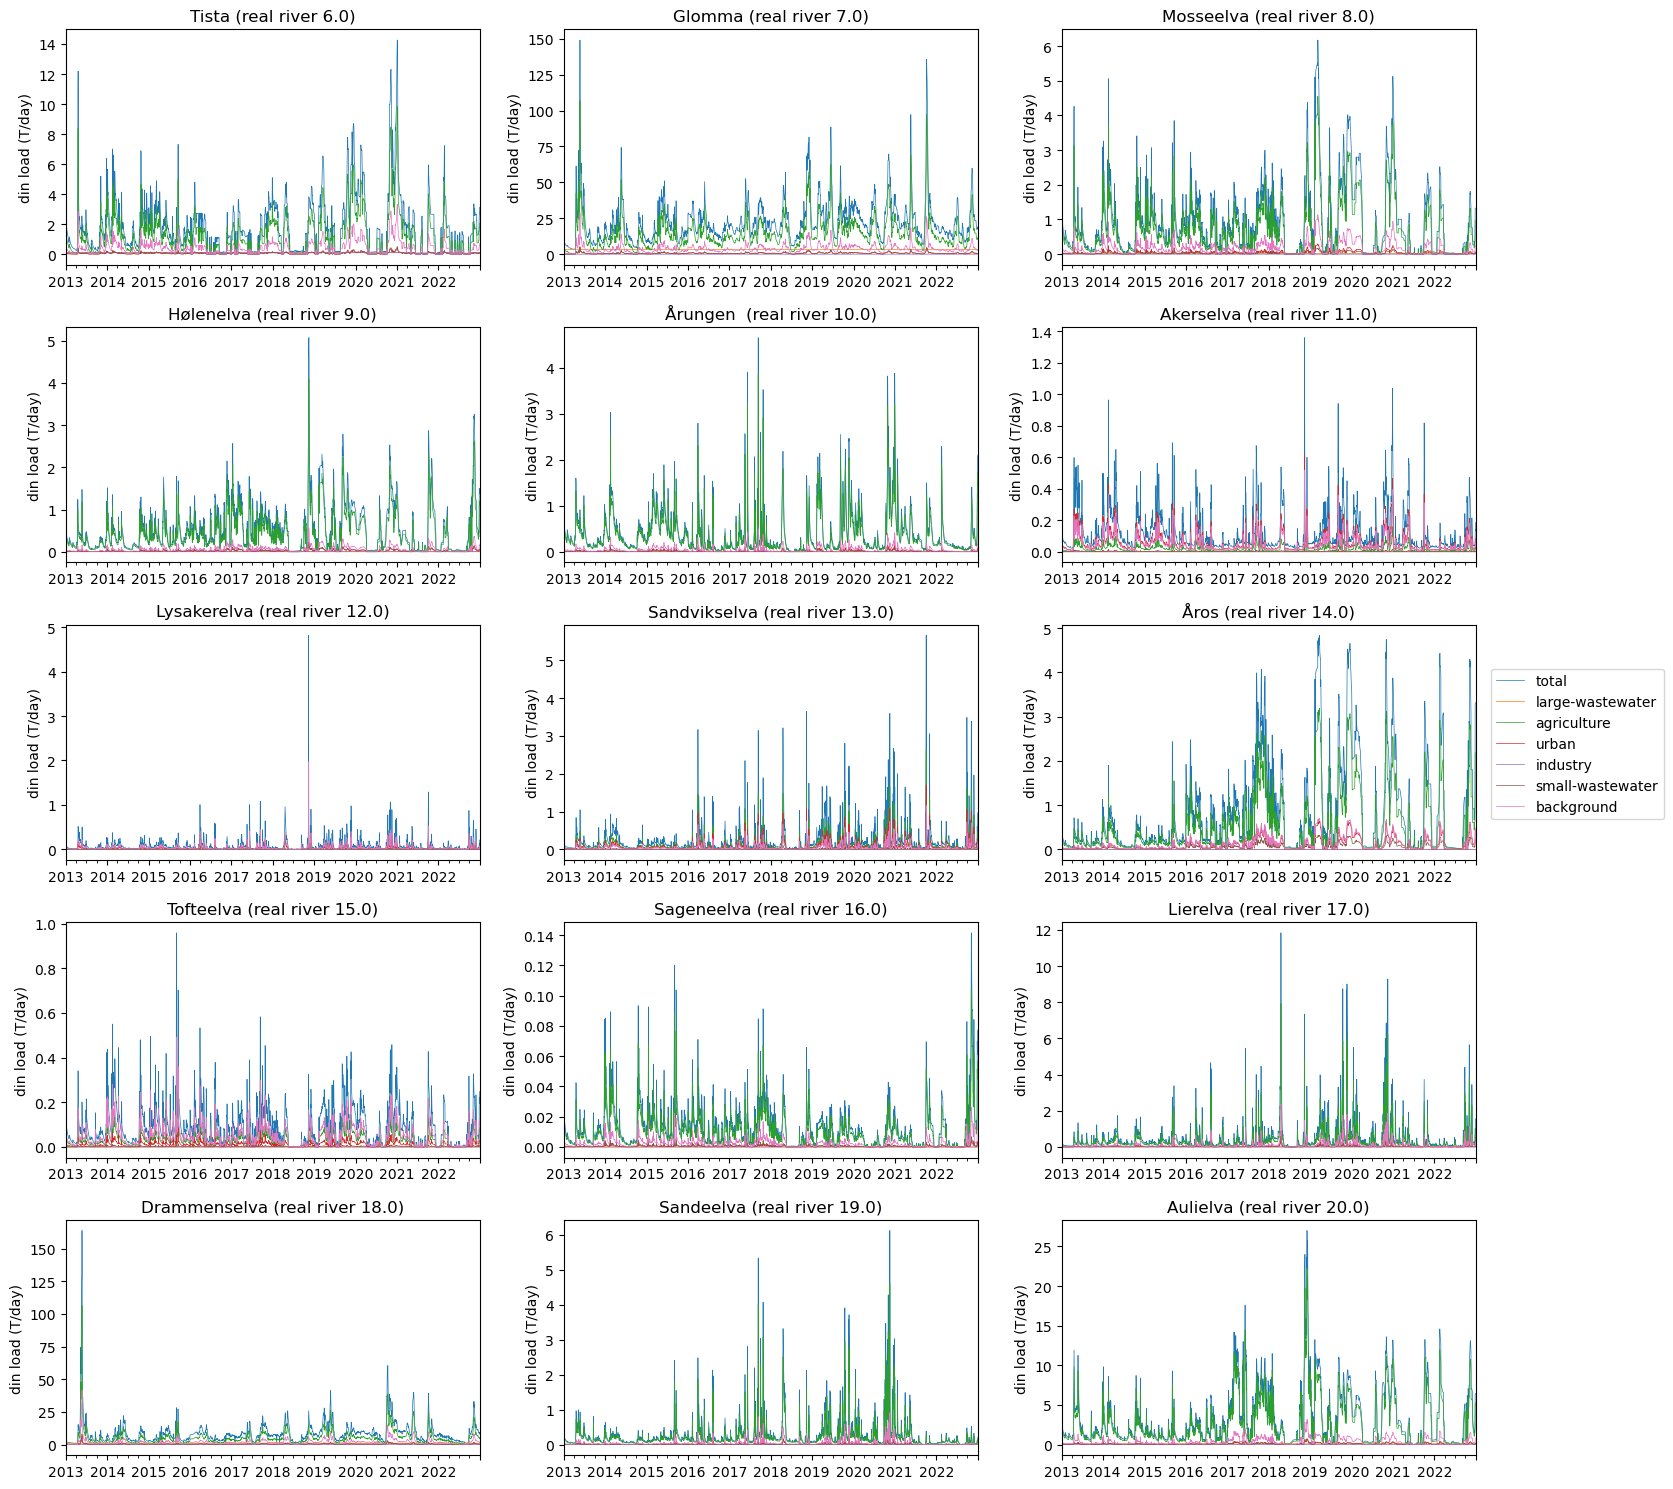

In [61]:
cols_to_plot = ['total', 'large-wastewater', 'agriculture', 'urban', 'industry', 'small-wastewater', 'background']


def plot_timeseries_allrivs(real_rivers_li, daily_load_dict, cols_to_plot, fpath):
    n_rows = int(np.ceil(len(real_rivers_li) / 3))
    fig, axs = plt.subplots(n_rows, 3, figsize=(15, n_rows*3), sharex=False, sharey=False)
    axs = axs.flatten()
    # color_li = ['k', 'r', '']

    # For each real_river
    for i, real_river in enumerate(real_rivers_li):
        name = river_meta_df.loc[real_river, 'river_name']
        df = daily_load_dict[real_river].copy()/1000  # to T/yr
        df[cols_to_plot].plot(ax=axs[i], linewidth=0.5, legend=False)
        axs[i].set_xlabel('')
        axs[i].set_ylabel(r'%s load (T/day)' % par)
        axs[i].set_title(f'{name} (real river {real_river})')

    handles, labels = axs[-1].get_legend_handles_labels()
    fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1.12, 0.5))

    plt.tight_layout()
    # fig.autofmt_xdate()

    plt.savefig(fpath)

    plt.show()

fpath = os.path.join(fig_folder, "daily_riv-only_sector-inputs_ts.png")
plot_timeseries_allrivs(real_rivers, daily_load_dict, cols_to_plot, fpath)

## Summarise (mean of annual sums) and check against TEOTIL

In [79]:
teotil_av_df_dict.keys()

dict_keys(['Vassom', 'Regine', 'scaled_regine', 'scaled_regine_wwtw'])

In [90]:
(teotil_av_df_dict['scaled_regine'].copy()/1000).round(1)

agriculture-background  agriculture  aquaculture  industry   lake  \
real_river                                                                      
6                             40.0        359.8          0.0      26.6   48.2   
7                            662.0       5958.1          0.0       3.0  287.0   
8                             23.0        207.4          0.0       0.0   14.8   
9                             21.2        190.8          0.0       0.0    0.2   
10                            29.5        265.9          0.0       0.0    2.5   
11                             1.1          9.5          0.0       0.0    8.9   
12                             1.5         13.2          0.0       0.0    2.6   
13                             4.8         43.0          0.0       0.0    1.5   
14                             8.7         78.5          0.0       0.0    1.5   
16                             3.6         32.7          0.0       0.0    2.9   
17                            10.8         96.8          0.0       0.1    3.6   
18                           154.3       1389.1          0.0       1.8  164.1   
19                            20.0        179.9          0.0       0.0    1.9   
20                            77.8        700.5          0.0       0.0    2.4   

            large-wastewater  spredt  upland  urban   wood  
real_river                                                  
6                       17.9    18.4     1.7   14.7   32.1  
7                     1342.0   293.6   205.0  268.9  446.1  
8                        4.2     7.9     0.3   13.5   13.7  
9                        2.3     8.9     0.1   10.6    4.9  
10                       0.3     8.0     0.0   12.6    2.2  
11                       0.0     1.0     0.1   27.8   13.4  
12                       0.0     1.0     0.2    9.5   12.2  
13                       0.4     3.0     0.2   28.0   12.7  
14                       0.0     7.8     0.1   15.7    6.9  
16                       0.0     2.1     0.0    1.9    3.8  
17                       2.5     7.7     0.2   10.8   14.4  
18                     293.1   106.3    56.0   87.6  165.3  
19                       0.0    10.6     0.2   12.4   13.6  
20                      15.8    22.4     0.2   22.8   19.9

In [99]:
calc_yr_source_inputs_df = pd.DataFrame(columns=daily_load_dict[7].columns, dtype=float)

for i, real_river in enumerate(real_rivers):
    name = river_meta_df.loc[real_river, 'river_name']
    daily_df = daily_load_dict[real_river].copy()/1000  # to T/yr
    yr_df = daily_df.groupby(daily_df.index.year).sum()
    yr_mean_df = yr_df.mean()
    calc_yr_source_inputs_df.loc[real_river, :] = yr_mean_df.values

calc_yr_source_inputs_df.round(1)

total  diffuse   point  agriculture  small-wastewater  urban  industry  \
6    679.4    614.0    65.4        429.2              21.9   17.5      31.7   
7   8352.0   7148.3  1203.7       5244.7             258.5  236.7       2.6   
8    341.8    335.7     6.2        248.2               9.4   16.1       0.0   
9    197.2    194.4     2.8        156.8               7.3    8.7       0.0   
10   150.0    149.1     0.8        123.6               3.7    5.9       0.0   
11    44.7     44.7     0.0          6.9               0.7   20.1       0.0   
12    29.8     29.8     0.0          9.8               0.8    7.0       0.0   
13    88.8     88.4     0.4         40.8               2.8   26.5       0.0   
14   310.9    310.9     0.0        204.8              20.3   40.9       0.0   
15    33.3     33.3     0.0         11.5               0.7    4.1       0.0   
16     4.7      4.7     0.0          3.5               0.2    0.1       0.0   
17   178.2    174.5     3.7        117.0               9.4   13.1       0.2   
18  3196.0   2801.8   394.2       1833.5             140.2  115.7       2.3   
19   100.2    100.2     0.0         75.6               4.5    5.2       0.0   
20  1213.0   1177.0    35.9        974.4              31.2   31.7       0.0   

    large-wastewater  background  
6               33.7       145.4  
7             1201.1      1408.5  
8                6.2        62.0  
9                2.8        21.7  
10               0.8        15.9  
11               0.0        17.0  
12               0.0        12.2  
13               0.4        18.2  
14               0.0        44.9  
15               0.0        17.0  
16               0.0         0.9  
17               3.5        35.0  
18             391.9       712.4  
19               0.0        15.0  
20              35.9       139.7

Still need to do a proper plot, but have done a quick manual check that the % from large-wastewater and agriculture here are the same as the %s from the teotil regine file. All seems to be working ok.
Absolute loads are of course different to the regine file, that comparison is done elsewhere (section 'Compare TEOTIL and river data annual loads for 2018').

# Generate scenarios

To do: move to new file!

In [110]:
# Factor giving proportion of the original load per sector
# (i.e. new load = old load * factor)

# # Read in scenarios info?
# scen_setup_df = pd.read_csv(scenario_setup_fpath, index_col=0)

# Or input directly
scenario = 'A100'
scenario_dict = {
    "agriculture": 0.9,
    "industry": 1,
    "large-wastewater": 0.25,
    "small-wastewater": 1,
    "urban": 1,
    "background": 1
}
scen_setup_df = pd.DataFrame(list(scenario_dict.items()), columns=['Sector', scenario])
scen_setup_df.set_index('Sector', inplace=True)

scen_setup_df

A100
Sector                
agriculture       0.90
industry          1.00
large-wastewater  0.25
small-wastewater  1.00
urban             1.00
background        1.00

In [111]:
main_results_dict = {}  # key: (scenario, type), where type is 'loads', 'factor', 'conc'
                        # Returns loads_dict, factor_dict, conc_dict (key: real riv no)

for scenario in scen_setup_df.columns:

    scenario_loads_dict = {}
    scenario_factor_dict = {}
    scenario_conc_dict = {}  # Key: river

    for riv_no in daily_load_dict.keys():

        baseline_df = daily_load_dict[riv_no].copy()

        # Calculate loads per sector for the scenario
        scen_load_df = pd.DataFrame(index=baseline_df.index)

        for source in scen_setup_df.index:
            scen_load_df[source] = baseline_df[source] * scen_setup_df.loc[source, scenario]

        scen_load_df['total'] = scen_load_df.sum(axis=1)
        scenario_loads_dict[riv_no] = scen_load_df

        # ---------------------------------------------------------
        # Factor to multiply concentration by to get new concentration
        factor_s = scen_load_df['total'] / baseline_df['total']
        # Replace any NaNs with 1 (i.e. concentration is unchanged)
        factor_s.fillna(1, inplace=True)
        factor_s.name = 'factor'
        scenario_factor_dict[riv_no] = factor_s

        # ---------------------------------------------------------
        # Calculate new daily concentration: C_scenario = L_scenario / Q
        # or (equivalent): C_scenario = C_baseline * (L_scenario/L_baseline)
        scen_load_df = scen_load_df[["total"]].copy()
        scen_load_df.columns = [f"{par}_load"]

        # Adjust the time component of the datetime index to be centered on midday
        # to match chem_df
        scen_load_df.index = scen_load_df.index + pd.tseries.offsets.DateOffset(
            hours=12
        )
        factor_s = factor_s.copy()  # To not alter dictionary item inplace
        factor_s.index = factor_s.index + pd.tseries.offsets.DateOffset(hours=12)

        # Join new total load to conc_df, and the factor
        df = conc_df.loc[conc_df["real_river"] == riv_no].copy()
        df.set_index("river_time", inplace=True)
        df = pd.merge(
            df,
            scen_load_df[[f"{par}_load"]],
            left_index=True,
            right_index=True,
            how="left",
        )
        df = pd.merge(df, factor_s, left_index=True, right_index=True, how="left")

        # Calculate new value for par (two methods to validate; they produce the same result)
        # df[f"{par}_new"] = df['din_load'] / df['river_transport'] * 1/86400 * 10**9 * 10**-3
        df[f"{par}"] = df[f"{par}"] * df["factor"]

        if par == 'din':
            # Assume NH4 and NO3 are reduced by the same amount as din
            df['river_NH4N'] = df['river_NH4N'] * df["factor"]
            df['river_NO3NO2N'] = df['river_NO3NO2N'] * df["factor"]

            # Calculate new TOTN
            df['river_TOTN'] = df['din'] + df['river_DON'] + df['river_PON']

            # Drop cols used in calculation
            df.drop(derived_chemvar_dict[species] + [f"{par}_load", 'factor'], axis=1, inplace=True)

        # Bit of QC
        # Check for NaNs
        if df.isna().sum().sum() > 0:
            print(f"{riv_no} has NaNs. Needs fixing!")

        scenario_conc_dict[riv_no] = df

    main_results_dict[(scenario, 'loads')] = scenario_loads_dict
    main_results_dict[(scenario, 'factor')] = scenario_factor_dict
    main_results_dict[(scenario, 'conc')] = scenario_conc_dict

**Quick check of output**

TO DO: looks like loads are different for each scenario, but not concentrations. Why?? Fix and debug

In [112]:
main_results_dict.keys()

dict_keys([('A100', 'loads'), ('A100', 'factor'), ('A100', 'conc')])

In [113]:
riv = 7
scen = 'A100'

scenario_loads_dict = main_results_dict[(scen, 'loads')]
scenario_factor_dict = main_results_dict[(scen, 'factor')]
scenario_conc_dict = main_results_dict[(scen, 'conc')]

# Baseline loads per sector + total
daily_load_dict[riv].copy().loc['2013-02-20': '2013-02-28']

total      diffuse        point  agriculture  \
date                                                             
2013-02-20  4471.508077  1175.518412  3295.989665   862.467849   
2013-02-21  4411.527088  1115.537424  3295.989665   818.460309   
2013-02-22  4353.893759  1057.904094  3295.989665   776.175225   
2013-02-23  4298.967060  1002.977395  3295.989665   735.875974   
2013-02-24  4244.102082   948.112417  3295.989665   695.622007   
2013-02-25  4190.203613   894.213949  3295.989665   656.077160   
2013-02-26  4137.422037   841.432372  3295.989665   617.351766   
2013-02-27  4091.345778   795.356114  3295.989665   583.546008   
2013-02-28  4053.973312   757.983647  3295.989665   556.126147   

            small-wastewater      urban  industry  large-wastewater  \
date                                                                  
2013-02-20         42.501480  38.918051  7.175898       3288.813767   
2013-02-21         40.332836  36.932252  7.175898       3288.813767   
2013-02-22         38.249073  35.024178  7.175898       3288.813767   
2013-02-23         36.263170  33.205712  7.175898       3288.813767   
2013-02-24         34.279498  31.389289  7.175898       3288.813767   
2013-02-25         32.330771  29.604865  7.175898       3288.813767   
2013-02-26         30.422425  27.857418  7.175898       3288.813767   
2013-02-27         28.756514  26.331965  7.175898       3288.813767   
2013-02-28         27.405293  25.094670  7.175898       3288.813767   

            background  
date                    
2013-02-20  231.631032  
2013-02-21  219.812027  
2013-02-22  208.455618  
2013-02-23  197.632539  
2013-02-24  186.821623  
2013-02-25  176.201153  
2013-02-26  165.800762  
2013-02-27  156.721626  
2013-02-28  149.357537

In [114]:
# Scenario loads
scenario_loads_dict[riv].copy().loc['2013-02-20': '2013-02-28']

agriculture  industry  large-wastewater  small-wastewater  \
date                                                                    
2013-02-20   776.221064  7.175898        822.203442         42.501480   
2013-02-21   736.614278  7.175898        822.203442         40.332836   
2013-02-22   698.557703  7.175898        822.203442         38.249073   
2013-02-23   662.288377  7.175898        822.203442         36.263170   
2013-02-24   626.059806  7.175898        822.203442         34.279498   
2013-02-25   590.469444  7.175898        822.203442         32.330771   
2013-02-26   555.616590  7.175898        822.203442         30.422425   
2013-02-27   525.191407  7.175898        822.203442         28.756514   
2013-02-28   500.513533  7.175898        822.203442         27.405293   

                urban  background        total  
date                                            
2013-02-20  38.918051  231.631032  1918.650966  
2013-02-21  36.932252  219.812027  1863.070732  
2013-02-22  35.024178  208.455618  1809.665911  
2013-02-23  33.205712  197.632539  1758.769137  
2013-02-24  31.389289  186.821623  1707.929556  
2013-02-25  29.604865  176.201153  1657.985572  
2013-02-26  27.857418  165.800762  1609.076535  
2013-02-27  26.331965  156.721626  1566.380852  
2013-02-28  25.094670  149.357537  1531.750372

In [115]:
# Factor for calculating concs
scenario_factor_dict[riv].loc['2013-02-20': '2013-02-28']

date
2013-02-20    0.429084
2013-02-21    0.422319
2013-02-22    0.415643
2013-02-23    0.409114
2013-02-24    0.402424
2013-02-25    0.395681
2013-02-26    0.388908
2013-02-27    0.382852
2013-02-28    0.377839
Name: factor, dtype: float64

In [116]:
# Original conc
conc_df.loc[conc_df["real_river"] == riv].set_index('river_time').loc['2013-02-20': '2013-02-28']

real_river  river_NH4N  river_NO3NO2N  river_TOTN  \
river_time                                                               
2013-02-20 12:00:00         7.0      38.369        375.727     552.318   
2013-02-21 12:00:00         7.0      39.442        374.956     551.807   
2013-02-22 12:00:00         7.0      40.523        374.170     551.435   
2013-02-23 12:00:00         7.0      41.578        373.393     551.111   
2013-02-24 12:00:00         7.0      42.552        372.667     550.854   
2013-02-25 12:00:00         7.0      43.400        372.027     550.680   
2013-02-26 12:00:00         7.0      44.099        371.491     550.589   
2013-02-27 12:00:00         7.0      44.646        371.063     550.578   
2013-02-28 12:00:00         7.0      45.054        370.736     550.634   

                     river_DON  river_PON  river_transport         din  \
river_time                                                               
2013-02-20 12:00:00    133.122      5.054       124.979630  414.096008   
2013-02-21 12:00:00    131.442      5.913       123.212997  414.398987   
2013-02-22 12:00:00    129.924      6.758       121.517097  414.692993   
2013-02-23 12:00:00    128.512      7.559       119.903709  414.971008   
2013-02-24 12:00:00    127.278      8.283       118.302757  415.218994   
2013-02-25 12:00:00    126.266      8.906       116.741875  415.427002   
2013-02-26 12:00:00    125.492      9.422       115.226135  415.589996   
2013-02-27 12:00:00    124.945      9.834       113.910301  415.709015   
2013-02-28 12:00:00    124.598     10.153       112.847534  415.790985   

                            ton  
river_time                       
2013-02-20 12:00:00  138.222000  
2013-02-21 12:00:00  137.408997  
2013-02-22 12:00:00  136.742996  
2013-02-23 12:00:00  136.139999  
2013-02-24 12:00:00  135.634995  
2013-02-25 12:00:00  135.253006  
2013-02-26 12:00:00  135.000000  
2013-02-27 12:00:00  134.869003  
2013-02-28 12:00:00  134.843994

In [117]:
# New concs
scenario_conc_dict[riv].loc['2013-02-20': '2013-02-28']

real_river  river_NH4N  river_NO3NO2N  river_TOTN  \
river_time                                                               
2013-02-20 12:00:00         7.0   16.463510     161.218309  315.857823   
2013-02-21 12:00:00         7.0   16.657097     158.350960  312.363474   
2013-02-22 12:00:00         7.0   16.843105     155.521180  309.046282   
2013-02-23 12:00:00         7.0   17.010157     152.760436  305.841597   
2013-02-24 12:00:00         7.0   17.123956     149.970234  302.655188   
2013-02-25 12:00:00         7.0   17.172572     147.204159  299.548732   
2013-02-26 12:00:00         7.0   17.150454     144.475822  296.540275   
2013-02-27 12:00:00         7.0   17.092821     142.062297  293.934123   
2013-02-28 12:00:00         7.0   17.023171     140.078625  291.853168   

                     river_DON  river_PON  river_transport  
river_time                                                  
2013-02-20 12:00:00    133.122      5.054       124.979630  
2013-02-21 12:00:00    131.442      5.913       123.212997  
2013-02-22 12:00:00    129.924      6.758       121.517097  
2013-02-23 12:00:00    128.512      7.559       119.903709  
2013-02-24 12:00:00    127.278      8.283       118.302757  
2013-02-25 12:00:00    126.266      8.906       116.741875  
2013-02-26 12:00:00    125.492      9.422       115.226135  
2013-02-27 12:00:00    124.945      9.834       113.910301  
2013-02-28 12:00:00    124.598     10.153       112.847534

In [70]:
# Check whether concentrations are different for a different scenario
main_results_dict[('S_pt-100', 'conc')][riv].loc['2013-02-20': '2013-02-28']

real_river  river_NH4N  river_NO3NO2N  river_TOTN  \
river_time                                                               
2013-02-20 12:00:00         7.0   10.086858      98.775178  247.038038   
2013-02-21 12:00:00         7.0    9.973650      94.814662  242.143562   
2013-02-22 12:00:00         7.0    9.846232      90.915396  237.443626   
2013-02-23 12:00:00         7.0    9.700422      87.115052  232.886476   
2013-02-24 12:00:00         7.0    9.505916      83.252053  228.318968   
2013-02-25 12:00:00         7.0    9.261814      79.392737  223.826551   
2013-02-26 12:00:00         7.0    8.968465      75.550560  219.433025   
2013-02-27 12:00:00         7.0    8.679166      72.134511  215.592679   
2013-02-28 12:00:00         7.0    8.423883      69.317631  212.492698   

                     river_DON  river_PON  river_transport  
river_time                                                  
2013-02-20 12:00:00    133.122      5.054       124.979630  
2013-02-21 12:00:00    131.442      5.913       123.212997  
2013-02-22 12:00:00    129.924      6.758       121.517097  
2013-02-23 12:00:00    128.512      7.559       119.903709  
2013-02-24 12:00:00    127.278      8.283       118.302757  
2013-02-25 12:00:00    126.266      8.906       116.741875  
2013-02-26 12:00:00    125.492      9.422       115.226135  
2013-02-27 12:00:00    124.945      9.834       113.910301  
2013-02-28 12:00:00    124.598     10.153       112.847534

## Generate netcdf files

Read in Phil's original file, truncate to the period I've updated (i.e. the date which TEOTIL covers), and then update the concentration columns for the variables that have been updated through the scenario.

In [71]:
ds_scen_dict = {}  # key: scenario name

for scenario in scen_setup_df.columns:

    # scenario_loads_dict = main_results_dict[(scenario, 'loads')]
    # scenario_factor_dict = main_results_dict[(scenario, 'factor')]
    scenario_conc_dict = main_results_dict[(scenario, 'conc')]

    update_cols_li = ["river_NH4N", "river_NO3NO2N", "river_TOTN"]

    # Read in original river file & truncate to start and end date of scenarios
    ds_scen = xr.open_dataset(fpath_baseline_data)
    ds_scen = ds_scen.sel(river_time=slice(start_date, end_date))
    # print(ds_scen.river_time.data[-1])  # Check not chopped end: ok

    # Update the relevant chemistry values
    for real_river, df in scenario_conc_dict.items():
        df = df.copy().reset_index()  # To not modify it inplace
        df_ds = xr.Dataset.from_dataframe(df)
        for col in update_cols_li:
            ds_scen[col].loc[
                {"real_river": real_river, "river_time": df_ds["river_time"]}
            ] = df_ds[col]

    # Update the 'History' attribute of the ds_scen dataset
    current_date = dt.datetime.now().date().strftime("%Y-%m-%d")
    existing_history = ds_scen.attrs["history"]
    new_history_str = (
        f"; Update {current_date}, Leah JB (NIVA, ljb@nivano): "
        "This is a daily concentration reduction scenario. See 'make_scenarios.ipynb', "
        "GitHub repository https://github.com/oslofjord-load-reductions/terrestrial-load-scenarios"
    )
    new_history = existing_history + new_history_str
    ds_scen.attrs['history'] = new_history

    # Save
    netcdf_fpath = os.path.join(netcdf_outfolder, f"river_din_reduction_{scenario}_v1.nc")
    ds_scen.to_netcdf(netcdf_fpath)
    ds_scen_dict[scenario] = ds_scen
    ds_scen.close()

# Quick plot of results

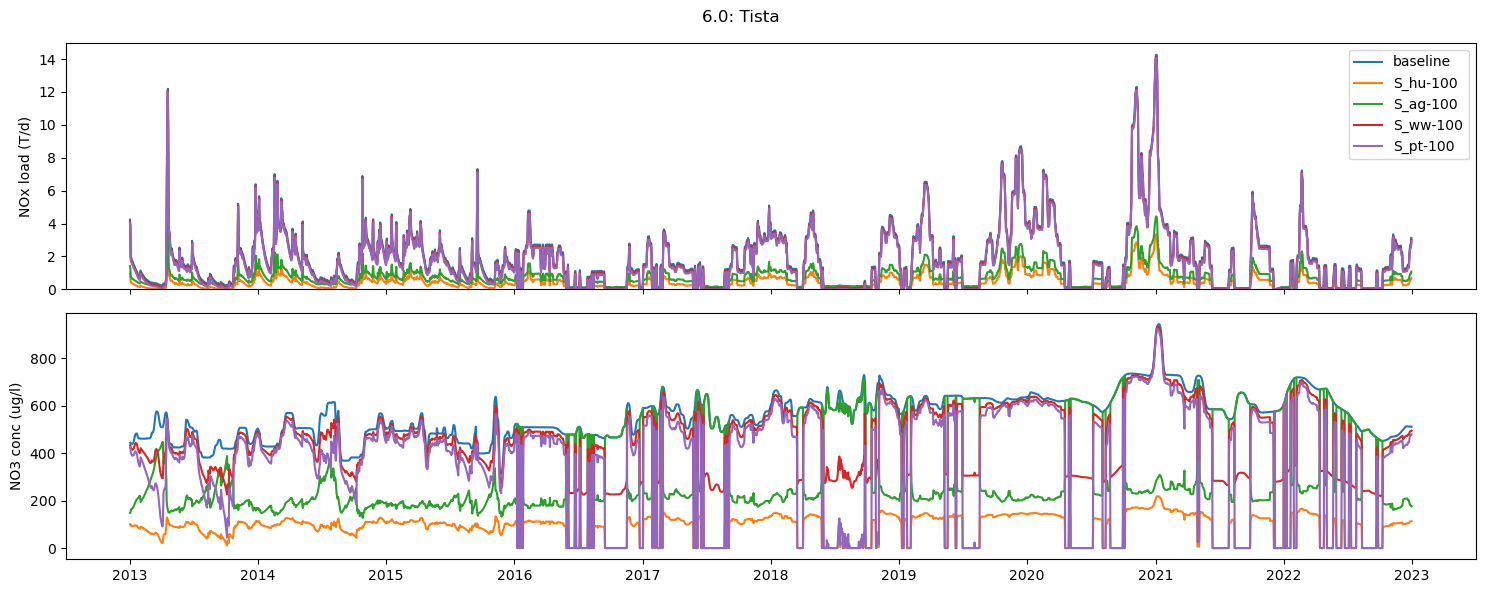

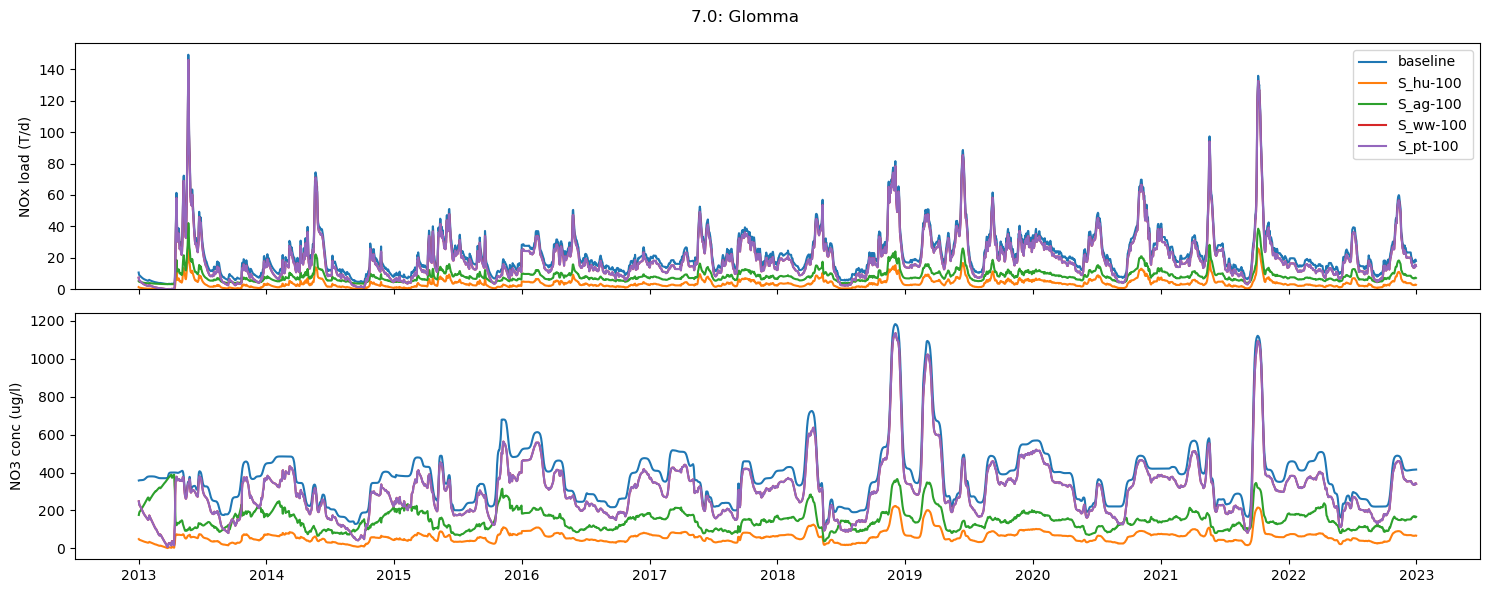

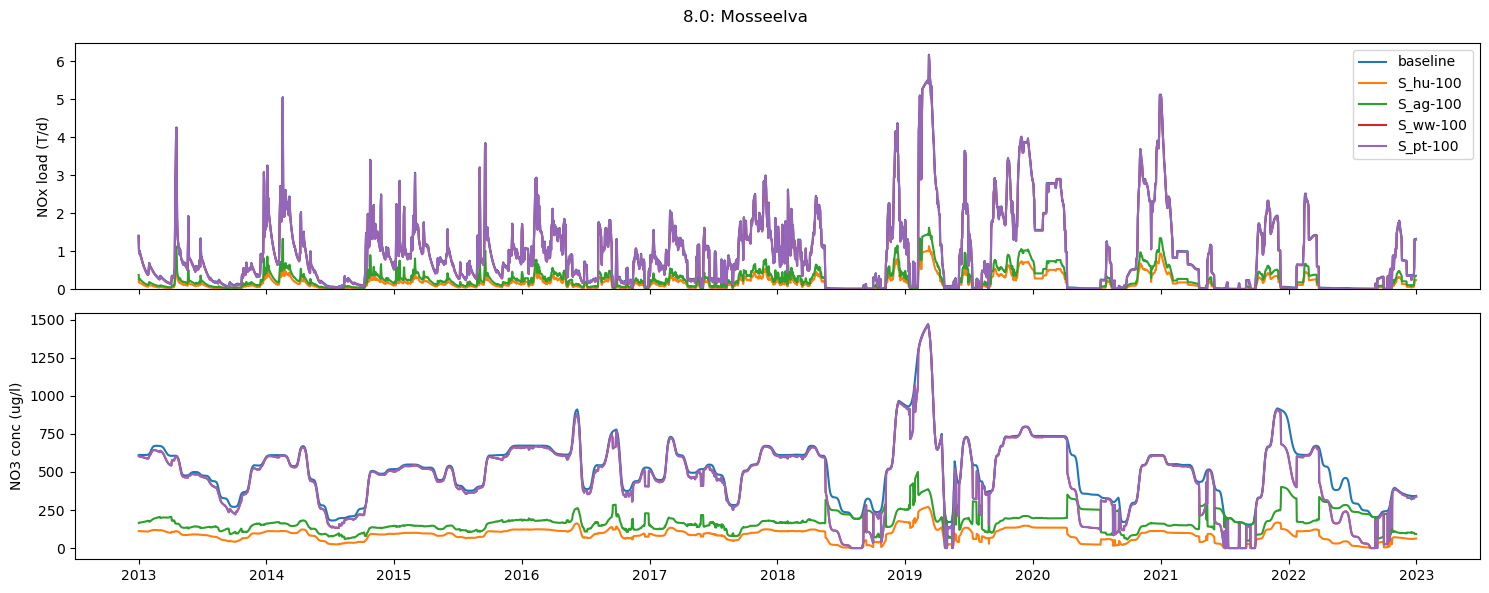

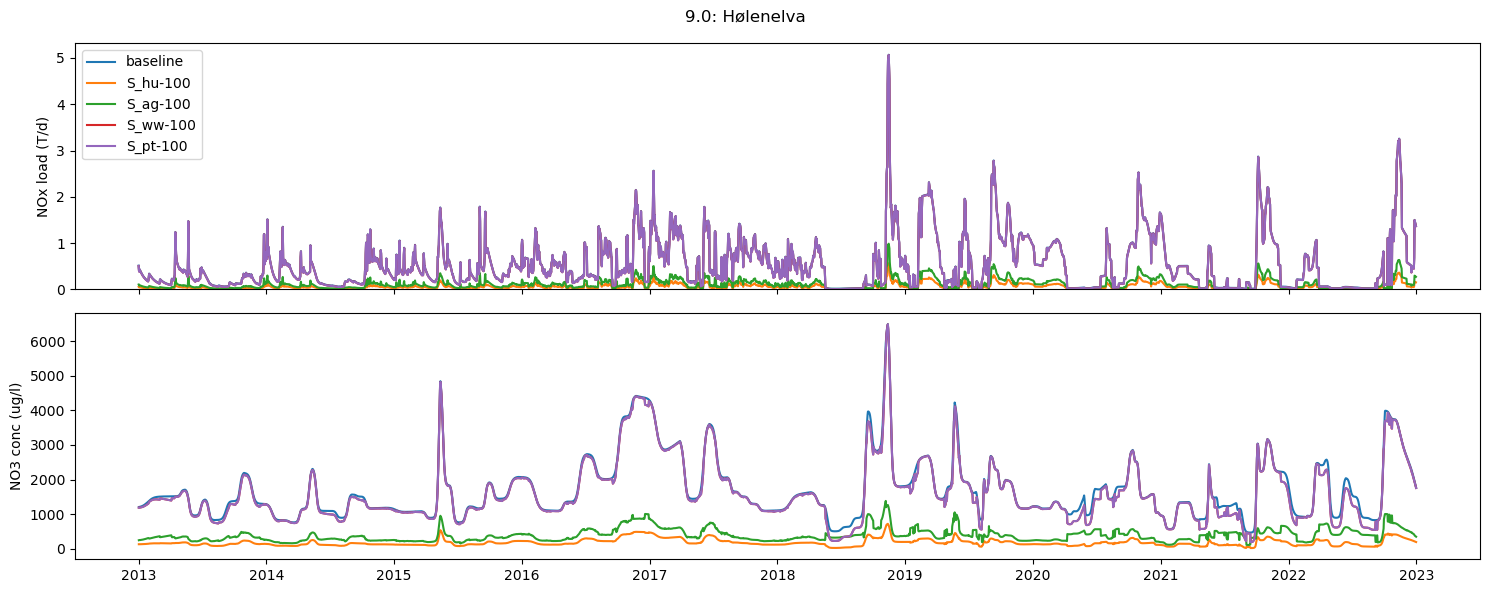

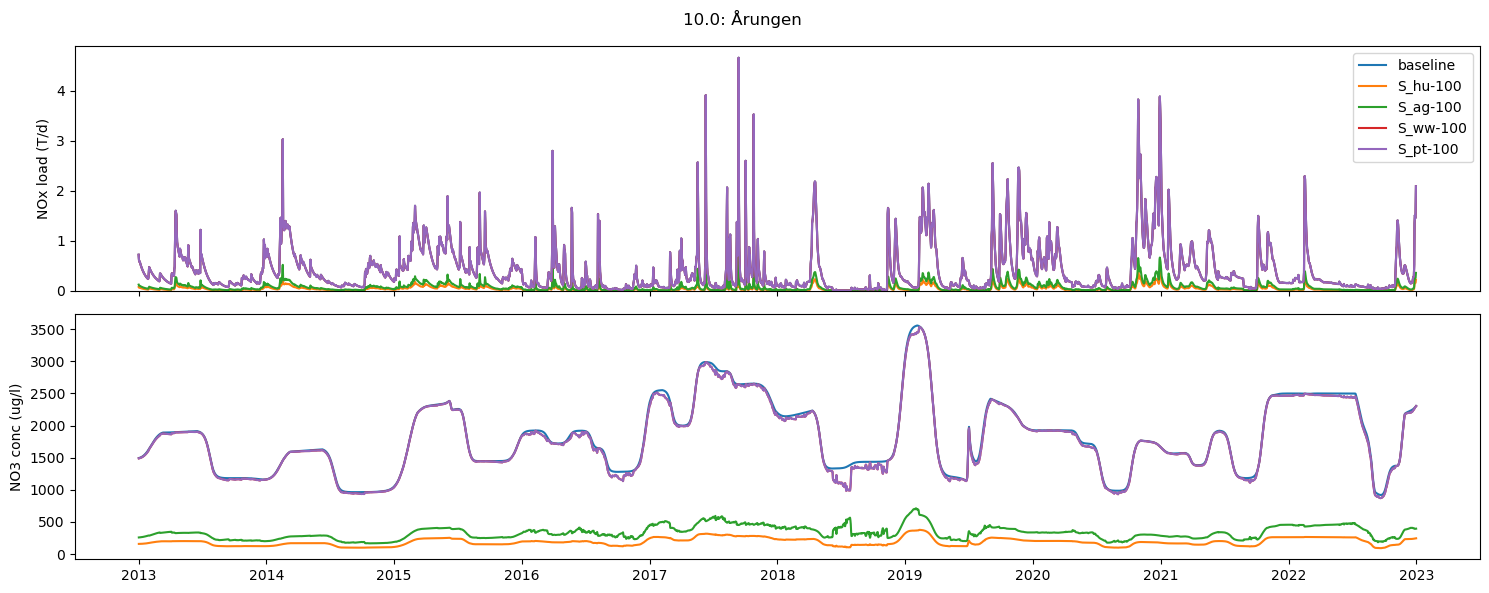

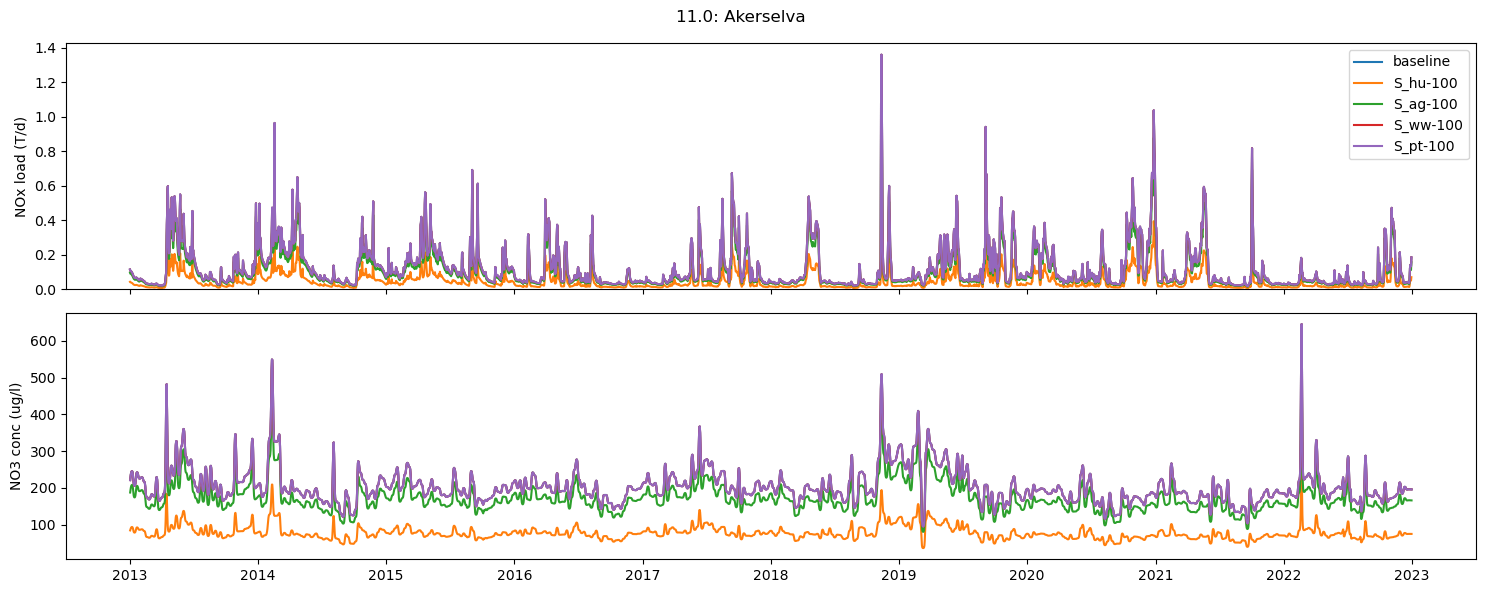

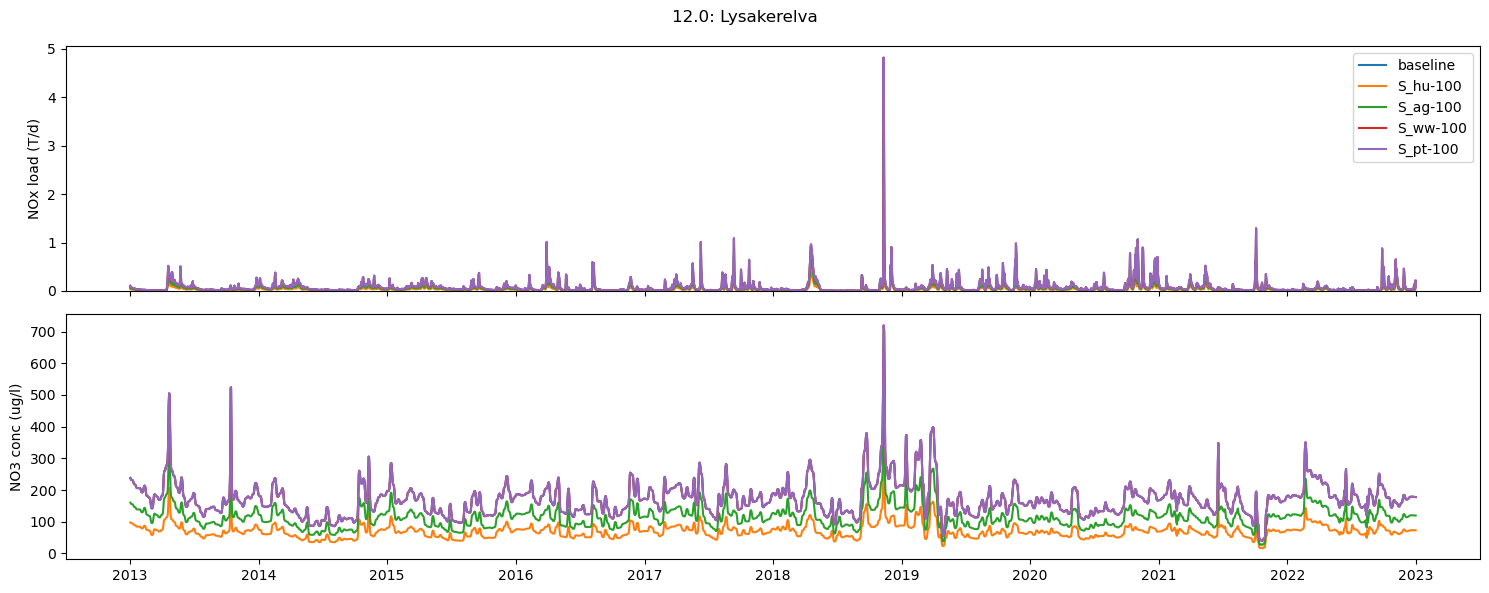

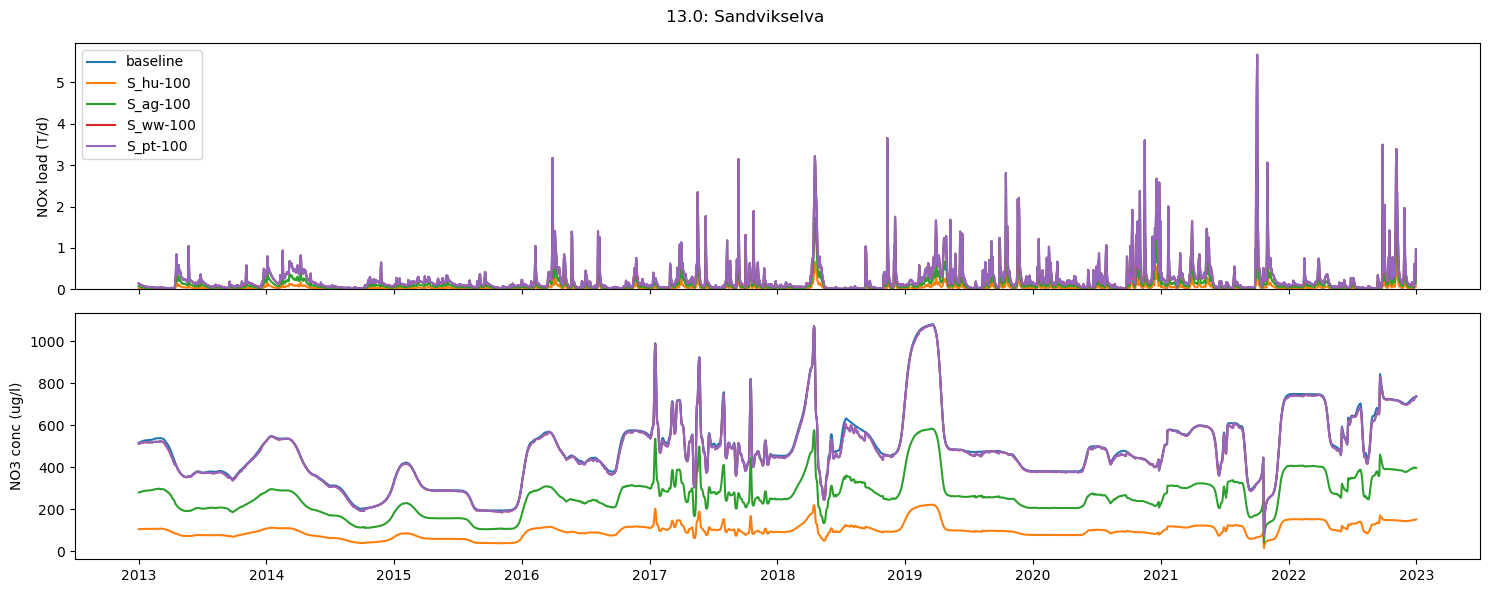

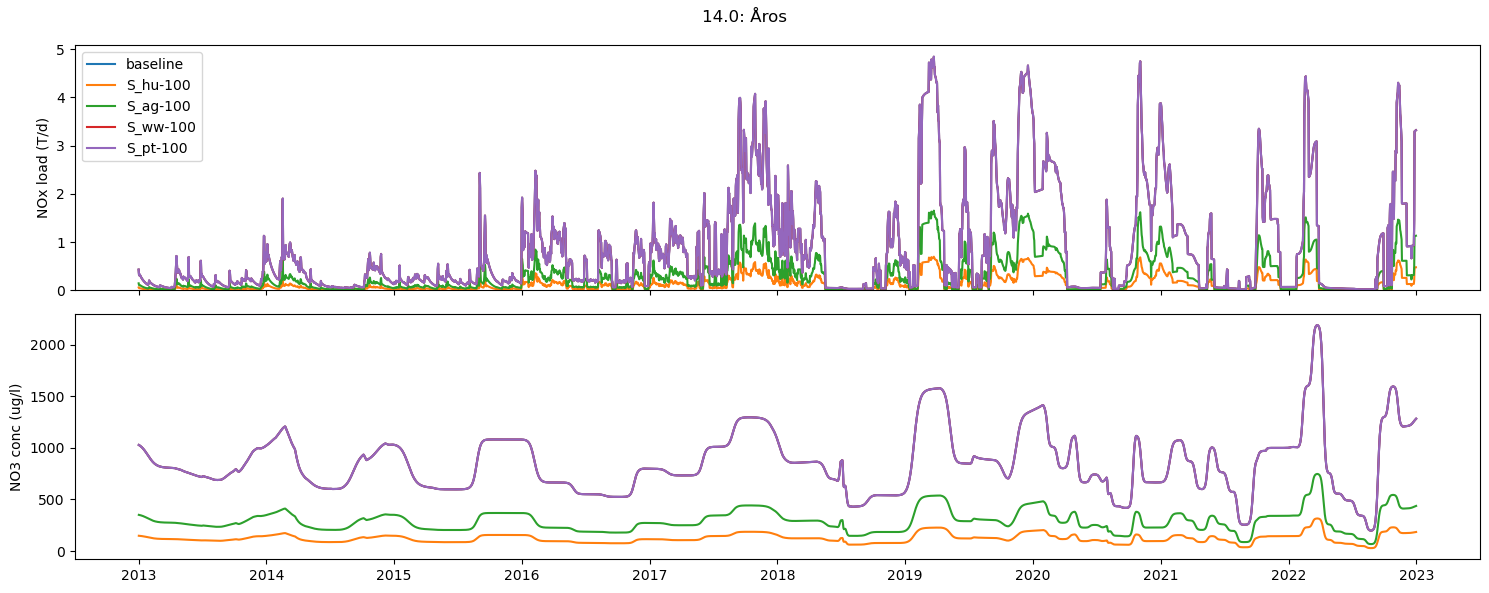

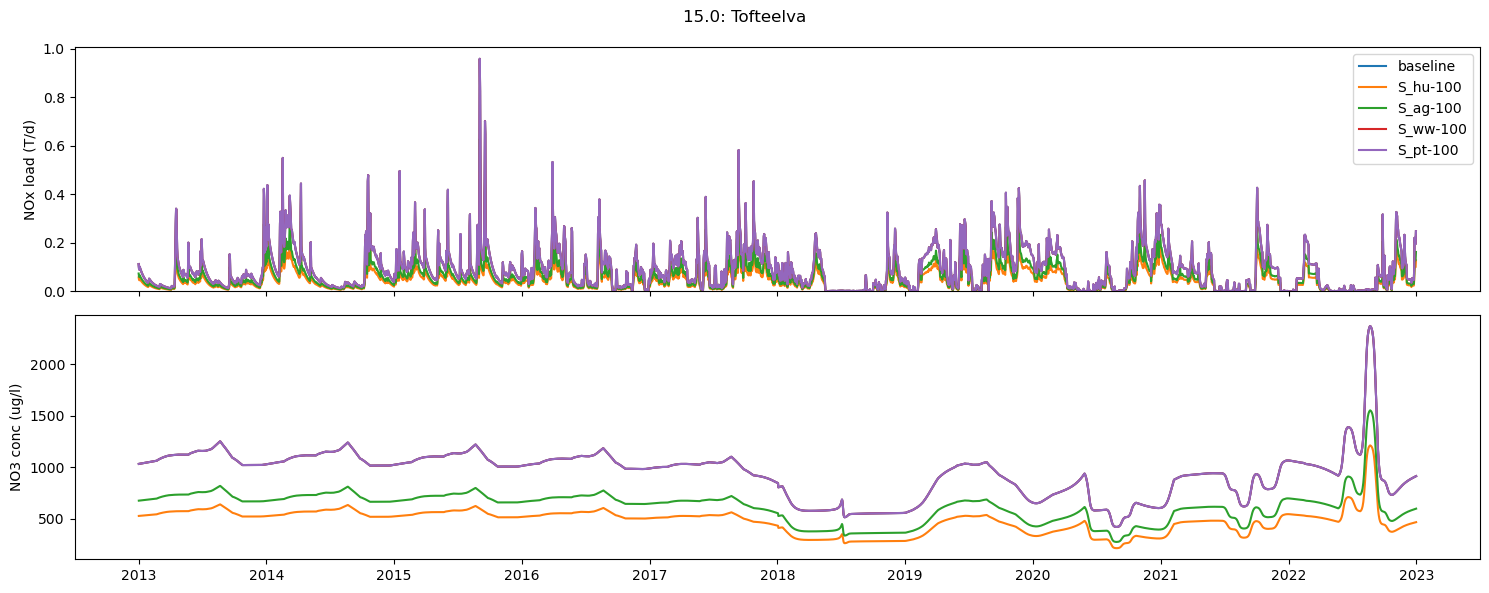

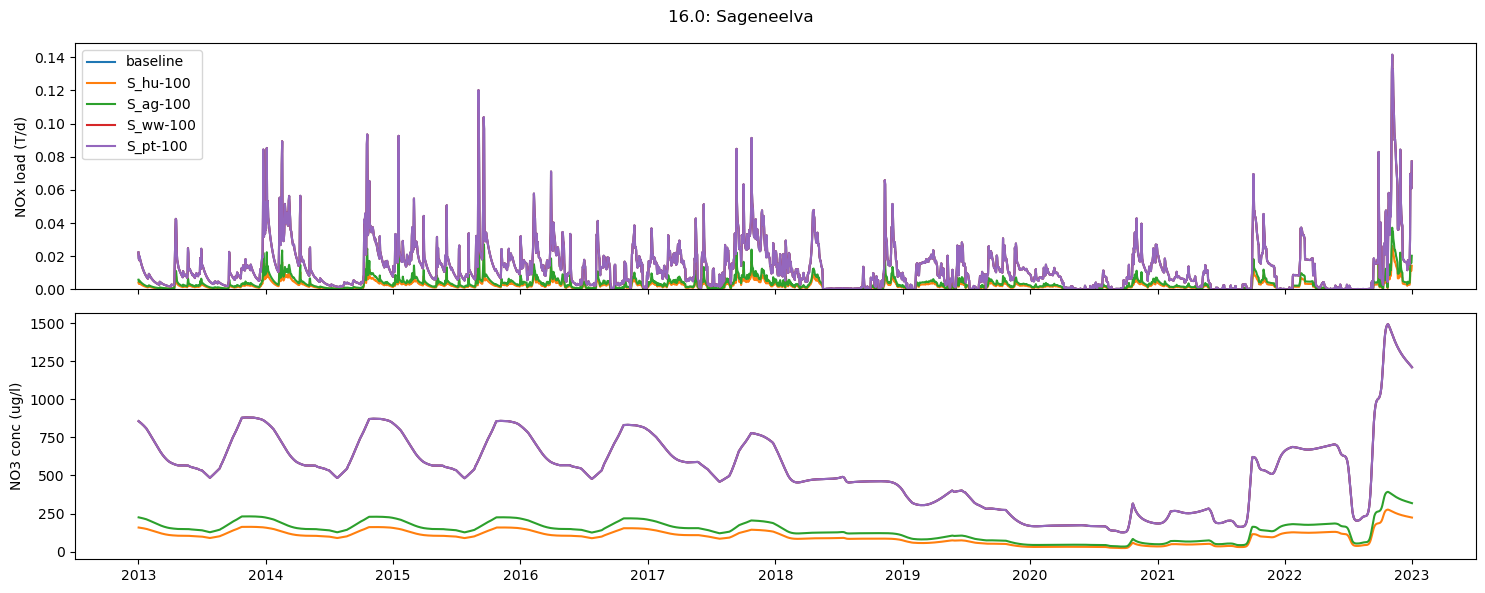

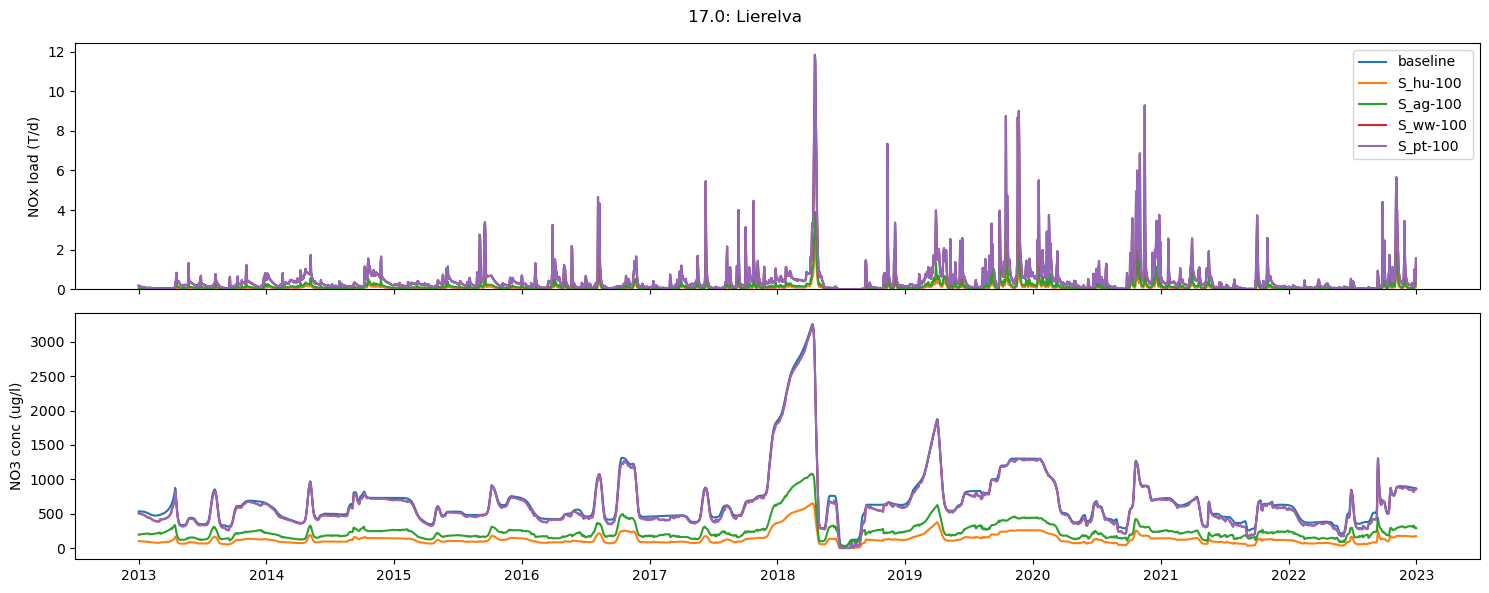

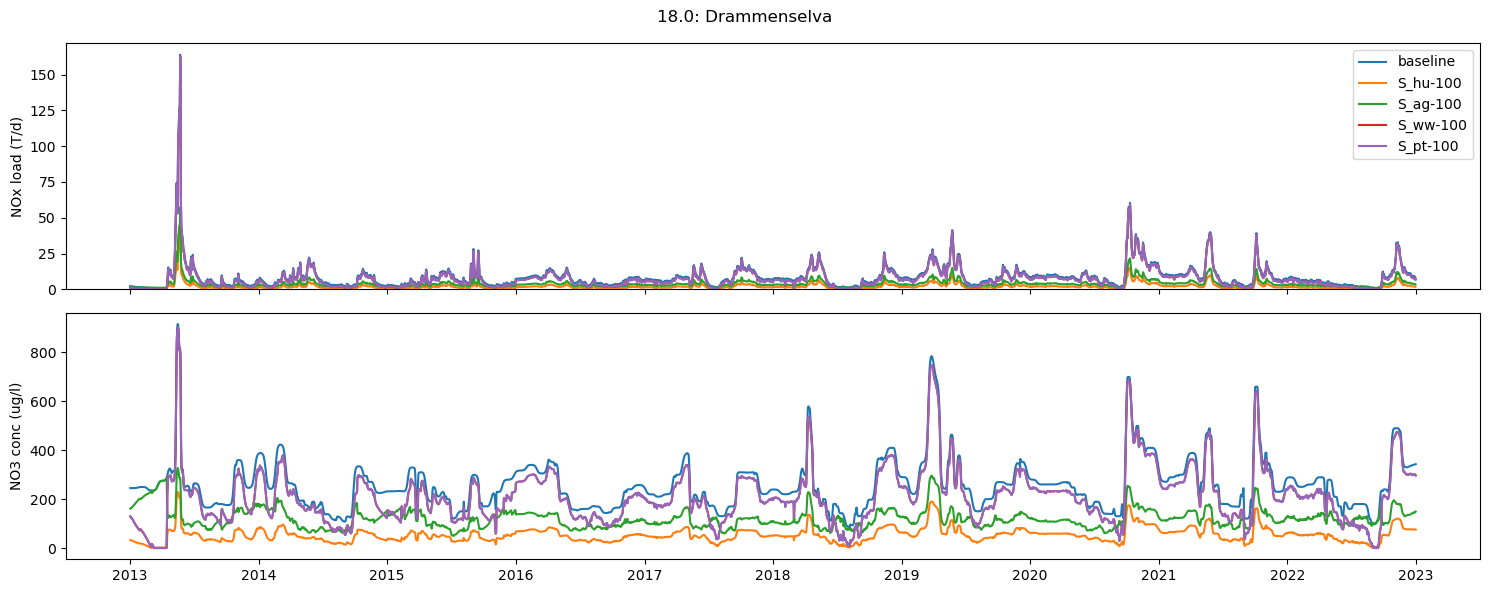

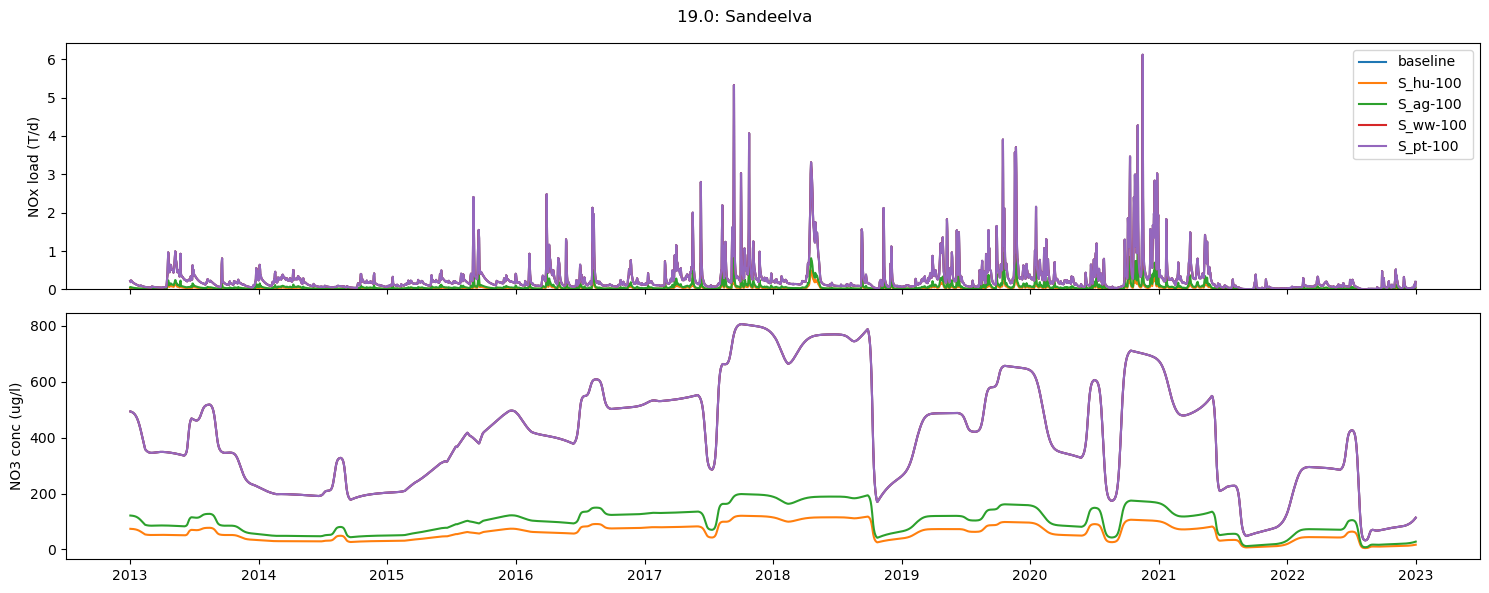

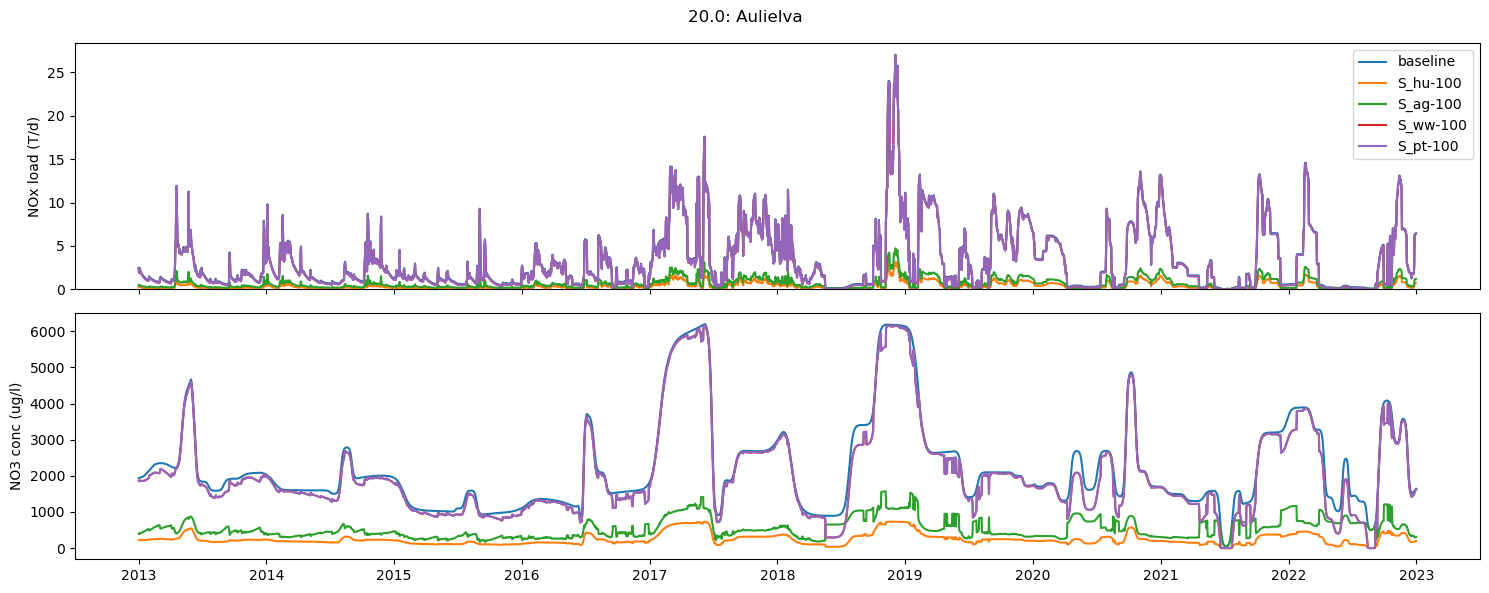

In [74]:
ds_bsl = xr.open_dataset(fpath_baseline_data)
ds_bsl = ds_bsl.sel(river_time=slice(start_date, end_date))

var = "river_NO3NO2N"

# To plot just one river:
# riv_no = 18
# st_dt = "2013-01-01"
# end_ds_dt = "2015-01-01"
# end_df_dt = "2014-12-31"
# name = river_meta_df.loc[riv_no, "river_name"]

for riv_no in riv_nos:

    riv_name = river_meta_df.loc[riv_no, "river_name"]

    # Select the baseline data
    plot_bsl_ds = ds_bsl.sel(real_river=riv_no)  #, river_time=slice(st_dt, end_ds_dt))
    plot_bsl_load_df = daily_load_dict[riv_no][["total"]].copy() / 1000  #.loc[st_dt:end_df_dt, :] / 1000

    # Plot the baseline
    fig, axs = plt.subplots(2, 1, figsize=(15, 6), sharex=True, sharey=False)
    axs = axs.flatten()

    # Loads
    axs[0].plot(plot_bsl_load_df.index.values, plot_bsl_load_df["total"], label="baseline")

    # Concentrations
    # axs[1].plot(plot_conc_df .index, plot_conc_df [var], label='df')
    axs[1].plot(plot_bsl_ds["river_time"].values, plot_bsl_ds[var].values, label="baseline")

    # Plot scenarios
    for scenario in scen_setup_df.columns:

        # Get concentration data
        plot_conc_df = main_results_dict[(scenario, 'conc')][riv_no].copy()
        # plot_conc_df = plot_conc_df.loc[st_dt: end_df_dt, :]  # gives same results as ds
        # plot_scen_ds = ds_scen_dict[scenario].copy().sel(real_river=riv_no)  #, river_time=slice(st_dt, end_ds_dt))

        # Get loads data
        plot_scen_load_df = (
            main_results_dict[(scenario, 'loads')][riv_no][["total"]]
            .copy() / 1000
            # .loc[st_dt : end_df_dt, :]
        )

        # Plot
        axs[0].plot(plot_scen_load_df.index.values, plot_scen_load_df["total"], label=scenario)
        axs[0].set_ylabel("NOx load (T/d)")
        axs[0].set_ylim(ymin=0)

        # axs[1].plot(plot_scen_ds["river_time"].values, plot_scen_ds[var].values, label=scenario)
        axs[1].plot(plot_conc_df.index, plot_conc_df[var].values, label=scenario)

        # --------------------------------------------------
    # Tidy up & save
    axs[1].set_ylabel("NO3 conc (ug/l)")
    axs[0].legend()
    plt.suptitle(f'{riv_no}: {riv_name}')
    plt.tight_layout()

    fpath = os.path.join(fig_folder, "scenario_tseries", f"scenario_ts_{riv_name}.png")
    plt.savefig(fpath)

    plt.show()

## Comments

* Scenario concentrations can have unrealistic step changes in them. This is especially bad for Tista, where the baseline concentration is smooth enough, but the baseline load is already very steppy, so then we get very steppy scenarios. Even more so as in Tista there was a lot of redistribution of negative mass, i.e. times when the scenario reduction factor = 1, so then the concentration hops up to the baseline.

# Seasonality in reductions

Glomma has the most sewage, so focus here. Question: how does the seasonality in daily load reduction vary by sector? Quick way of looking at this: 100% reduction in sewage vs point sources. Pick Glomma, which has 60% agricultural DIN and 19% point source inputs. So if reduce annual inputs by 100% for either of these, expect annual load to reduce by 100%. But how is this distributed through the seasons?

In [69]:
riv_no = 7  # Glomma
riv_name = 'Glomma'
# Scenarios: "S_ag-100", "S_pt-100"

df = daily_load_dict[riv_no][["total"]].copy()
pt100_df =  main_results_dict[("S_pt-100", 'loads')][riv_no][["total"]].copy()
ag100_df =  main_results_dict[("S_ag-100", 'loads')][riv_no][["total"]].copy()

In [70]:
def explore_seasonality(scen_df, flat_f, title):
    """
    flat_f is % contribution to total
    """
    df.rename(columns={'total': 'baseline'}, inplace=True)
    df['flat'] = df['baseline'] * (1 - flat_f)
    df['f_scen'] = 100 * (df['baseline'] - scen_df['total']) / df['baseline']
    df['f_flat'] = 100 * (df['baseline'] - df['flat']) / df['baseline']
    df['month'] = df.index.month
    # df_long = pd.melt(df, id_vars='month', value_vars=['f_scen', 'f_flat'],
    #                   var_name='scen', value_name='f')

    print("Flat percent reduction: %s" % round(df['f_flat'].mean()))
    print("Mean percent reduction compared to baseline: %s" % round(df['f_scen'].mean()))

    # Calculate total % reduction in load over whole time period; should be same as flat_f
    total_f = 100 * (df['baseline'].sum() - scen_df['total'].sum()) / df['baseline'].sum()
    print("Total percent reduction over whole period: %s" % round(total_f, 1))

    # Plot
    fig, ax = plt.subplots(figsize=(6, 3))
    # sns.boxplot(x='month', y='f', hue='scen', data=df_long)
    sns.boxplot(x=df['month'], y=df['f_scen'], ax=ax)
    plt.axhline(y=flat_f*100, color='red')
    plt.ylabel('% reduction in daily load')
    plt.xlabel('Month')
    plt.title(title)

    plt.tight_layout()
    fpath = os.path.join(fig_folder, f"seasonality_{riv_name}_{title}.png")
    plt.savefig(fpath)

    plt.show()

    return f_df

In [1]:
f_df = explore_seasonality(pt100_df, 0.19, "100% reduction in point sources")

NameError: name 'explore_seasonality' is not defined

In [ ]:
f_df = explore_seasonality(ag100_df, 0.60, "100% reduction in agricultural inputs")